## Medical Transcriptions Text Classification

import library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE

In [ ]:
pip install xgboost --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 45 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
import nltk
nltk.download('punkt')
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

read csv

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/case study 2/mtsamples.csv")

In [ ]:
df

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...,...,...,...,...
4994,4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e...",NaN
4995,4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN
4997,4997,Mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"CHIEF COMPLAINT: , This 5-year-old male presen...",NaN


target column values

In [ ]:
df.medical_specialty.value_counts()

 Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
 ENT - Otolaryngology               98
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    62
 Psychiatry / Psychology            53
 Office Notes                       51
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


In [ ]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count

In [ ]:
clinical_text_df = df[df['transcription'].notna()]
sent_count,word_count= get_sentence_word_count(clinical_text_df['transcription'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))



data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

Number of sentences in transcriptions column: 140208
Number of unique words in transcriptions column: 35805
===========Original Categories =======================
Cat:1  Allergy / Immunology : 7
Cat:2  Autopsy : 8
Cat:3  Bariatrics : 18
Cat:4  Cardiovascular / Pulmonary : 371
Cat:5  Chiropractic : 14
Cat:6  Consult - History and Phy. : 516
Cat:7  Cosmetic / Plastic Surgery : 27
Cat:8  Dentistry : 27
Cat:9  Dermatology : 29
Cat:10  Diets and Nutritions : 10
Cat:11  Discharge Summary : 108
Cat:12  ENT - Otolaryngology : 96
Cat:13  Emergency Room Reports : 75
Cat:14  Endocrinology : 19
Cat:15  Gastroenterology : 224
Cat:16  General Medicine : 259
Cat:17  Hematology - Oncology : 90
Cat:18  Hospice - Palliative Care : 6
Cat:19  IME-QME-Work Comp etc. : 16
Cat:20  Lab Medicine - Pathology : 8
Cat:21  Letters : 23
Cat:22  Nephrology : 81
Cat:23  Neurology : 223
Cat:24  Neurosurgery : 94
Cat:25  Obstetrics / Gynecology : 155
Cat:26  Office Notes : 50
Cat:27  Ophthalmology : 83
Cat:28  Orthoped

Since some catgeories have less than 50 samples i remove them

In [ ]:
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
i=1
print('============Reduced Categories ======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============ Reduced Categories ======================')

============Reduced Categories ======================
Cat:1  Cardiovascular / Pulmonary : 371
Cat:2  Consult - History and Phy. : 516
Cat:3  Discharge Summary : 108
Cat:4  ENT - Otolaryngology : 96
Cat:5  Emergency Room Reports : 75
Cat:6  Gastroenterology : 224
Cat:7  General Medicine : 259
Cat:8  Hematology - Oncology : 90
Cat:9  Nephrology : 81
Cat:10  Neurology : 223
Cat:11  Neurosurgery : 94
Cat:12  Obstetrics / Gynecology : 155
Cat:13  Ophthalmology : 83
Cat:14  Orthopedic : 355
Cat:15  Pain Management : 61
Cat:16  Pediatrics - Neonatal : 70
Cat:17  Psychiatry / Psychology : 53
Cat:18  Radiology : 273
Cat:19  SOAP / Chart / Progress Notes : 166
Cat:20  Surgery : 1088
Cat:21  Urology : 156
============ Reduced Categories ======================


We are interested only in the 'transcription' and 'medical_specialty' columns in the dataset

In [ ]:
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

(4597, 2)

In [ ]:
data

,transcription,medical_specialty
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary
7,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",Cardiovascular / Pulmonary
9,"DESCRIPTION:,1. Normal cardiac chambers size....",Cardiovascular / Pulmonary
11,"2-D STUDY,1. Mild aortic stenosis, widely calc...",Cardiovascular / Pulmonary
...,...,...
4972,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...",Cardiovascular / Pulmonary
4973,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...",Cardiovascular / Pulmonary
4974,"HISTORY OF PRESENT ILLNESS: , The patient is a...",Cardiovascular / Pulmonary
4975,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...",Cardiovascular / Pulmonary


In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
def clean_text(text ): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text2 = BAD_SYMBOLS_RE.sub('', text2)
    text2=re.sub(r'@[A-Z0-9a-z_:]+','',text2)#replace username-tags
    text2=re.sub(r'^[RT]+','',text2)#replace RT-tags
    text2 = re.sub('https?://[A-Za-z0-9./]+','',text2)#replace URLs
    text2=re.sub("[^a-zA-Z]", " ",text2)#replace hashtags

    return text2

In [ ]:
data['transcription'] = data['transcription'].apply(clean_text)

In [ ]:
data

,transcription,medical_specialty
3,d mmode left atrial enlargement with left a...,Cardiovascular / Pulmonary
4,the left ventricular cavity size and wall th...,Cardiovascular / Pulmonary
7,d echocardiogrammultiple views of the heart an...,Cardiovascular / Pulmonary
9,description normal cardiac chambers size nor...,Cardiovascular / Pulmonary
11,d study mild aortic stenosis widely calcified ...,Cardiovascular / Pulmonary
...,...,...
4972,indication chest paintype of test adenosine ...,Cardiovascular / Pulmonary
4973,chief complaint chest painhistory of present ...,Cardiovascular / Pulmonary
4974,history of present illness the patient is a y...,Cardiovascular / Pulmonary
4975,history of present illness mr abc is a yearol...,Cardiovascular / Pulmonary


RegexpTokenizer

In [ ]:
from nltk.tokenize import RegexpTokenizer
regexp = RegexpTokenizer('\w+')

data['transcription_Tokenizer']=data['transcription'].apply(regexp.tokenize)
data.head(10)

,transcription,medical_specialty,transcription_Tokenizer
3,d mmode left atrial enlargement with left a...,Cardiovascular / Pulmonary,"[d, mmode, left, atrial, enlargement, with, le..."
4,the left ventricular cavity size and wall th...,Cardiovascular / Pulmonary,"[the, left, ventricular, cavity, size, and, wa..."
7,d echocardiogrammultiple views of the heart an...,Cardiovascular / Pulmonary,"[d, echocardiogrammultiple, views, of, the, he..."
9,description normal cardiac chambers size nor...,Cardiovascular / Pulmonary,"[description, normal, cardiac, chambers, size,..."
11,d study mild aortic stenosis widely calcified ...,Cardiovascular / Pulmonary,"[d, study, mild, aortic, stenosis, widely, cal..."
12,cc confusion and slurred speechhx primarily o...,Neurology,"[cc, confusion, and, slurred, speechhx, primar..."
16,preoperative diagnosesairway obstruction secon...,Cardiovascular / Pulmonary,"[preoperative, diagnosesairway, obstruction, s..."
18,procedure elective male sterilization via bil...,Urology,"[procedure, elective, male, sterilization, via..."
19,history of present illness the patient is a y...,General Medicine,"[history, of, present, illness, the, patient, ..."
20,indication prostate cancertechnique hours f...,Urology,"[indication, prostate, cancertechnique, hours,..."


In [ ]:
stopwords = nltk.corpus.stopwords.words("english")
# Remove stopwords
data['transcription_Tokenizer'] = data['transcription_Tokenizer'].apply(lambda x: [i for i in x if i not in stopwords])
data.head(10)

,transcription,medical_specialty,transcription_Tokenizer
3,d mmode left atrial enlargement with left a...,Cardiovascular / Pulmonary,"[mmode, left, atrial, enlargement, left, atria..."
4,the left ventricular cavity size and wall th...,Cardiovascular / Pulmonary,"[left, ventricular, cavity, size, wall, thickn..."
7,d echocardiogrammultiple views of the heart an...,Cardiovascular / Pulmonary,"[echocardiogrammultiple, views, heart, great, ..."
9,description normal cardiac chambers size nor...,Cardiovascular / Pulmonary,"[description, normal, cardiac, chambers, size,..."
11,d study mild aortic stenosis widely calcified ...,Cardiovascular / Pulmonary,"[study, mild, aortic, stenosis, widely, calcif..."
12,cc confusion and slurred speechhx primarily o...,Neurology,"[cc, confusion, slurred, speechhx, primarily, ..."
16,preoperative diagnosesairway obstruction secon...,Cardiovascular / Pulmonary,"[preoperative, diagnosesairway, obstruction, s..."
18,procedure elective male sterilization via bil...,Urology,"[procedure, elective, male, sterilization, via..."
19,history of present illness the patient is a y...,General Medicine,"[history, present, illness, patient, yearold, ..."
20,indication prostate cancertechnique hours f...,Urology,"[indication, prostate, cancertechnique, hours,..."


In [ ]:
data['text_string'] = data['transcription_Tokenizer'].apply(lambda x: ' '.join([i for i in x if len(i)>2]))

In [ ]:
data

,transcription,medical_specialty,transcription_Tokenizer,text_string
3,d mmode left atrial enlargement with left a...,Cardiovascular / Pulmonary,"[mmode, left, atrial, enlargement, left, atria...",mmode left atrial enlargement left atrial diam...
4,the left ventricular cavity size and wall th...,Cardiovascular / Pulmonary,"[left, ventricular, cavity, size, wall, thickn...",left ventricular cavity size wall thickness ap...
7,d echocardiogrammultiple views of the heart an...,Cardiovascular / Pulmonary,"[echocardiogrammultiple, views, heart, great, ...",echocardiogrammultiple views heart great vesse...
9,description normal cardiac chambers size nor...,Cardiovascular / Pulmonary,"[description, normal, cardiac, chambers, size,...",description normal cardiac chambers size norma...
11,d study mild aortic stenosis widely calcified ...,Cardiovascular / Pulmonary,"[study, mild, aortic, stenosis, widely, calcif...",study mild aortic stenosis widely calcified mi...
...,...,...,...,...
4972,indication chest paintype of test adenosine ...,Cardiovascular / Pulmonary,"[indication, chest, paintype, test, adenosine,...",indication chest paintype test adenosine nucle...
4973,chief complaint chest painhistory of present ...,Cardiovascular / Pulmonary,"[chief, complaint, chest, painhistory, present...",chief complaint chest painhistory present illn...
4974,history of present illness the patient is a y...,Cardiovascular / Pulmonary,"[history, present, illness, patient, yearold, ...",history present illness patient yearold woman ...
4975,history of present illness mr abc is a yearol...,Cardiovascular / Pulmonary,"[history, present, illness, mr, abc, yearold, ...",history present illness abc yearold gentleman ...


In [ ]:
all_words = ' '.join([i for i in data['text_string']])

In [ ]:
tokenized_words = nltk.tokenize.word_tokenize(all_words)

In [ ]:
from nltk.probability import FreqDist

freq_dist = FreqDist(tokenized_words)
freq_dist

FreqDist({'patient': 20216, 'right': 10295, 'left': 10000, 'history': 7618, 'placed': 6662, 'normal': 6230, 'well': 5469, 'procedure': 4818, 'pain': 4777, 'also': 3914, ...})

In [ ]:
data['text_string_freq_dist'] = data['transcription_Tokenizer'].apply(lambda x: ' '.join([i for i in x if freq_dist[i] >= 1 ]))

In [ ]:
data

,transcription,medical_specialty,transcription_Tokenizer,text_string,text_string_freq_dist
3,d mmode left atrial enlargement with left a...,Cardiovascular / Pulmonary,"[mmode, left, atrial, enlargement, left, atria...",mmode left atrial enlargement left atrial diam...,mmode left atrial enlargement left atrial diam...
4,the left ventricular cavity size and wall th...,Cardiovascular / Pulmonary,"[left, ventricular, cavity, size, wall, thickn...",left ventricular cavity size wall thickness ap...,left ventricular cavity size wall thickness ap...
7,d echocardiogrammultiple views of the heart an...,Cardiovascular / Pulmonary,"[echocardiogrammultiple, views, heart, great, ...",echocardiogrammultiple views heart great vesse...,echocardiogrammultiple views heart great vesse...
9,description normal cardiac chambers size nor...,Cardiovascular / Pulmonary,"[description, normal, cardiac, chambers, size,...",description normal cardiac chambers size norma...,description normal cardiac chambers size norma...
11,d study mild aortic stenosis widely calcified ...,Cardiovascular / Pulmonary,"[study, mild, aortic, stenosis, widely, calcif...",study mild aortic stenosis widely calcified mi...,study mild aortic stenosis widely calcified mi...
...,...,...,...,...,...
4972,indication chest paintype of test adenosine ...,Cardiovascular / Pulmonary,"[indication, chest, paintype, test, adenosine,...",indication chest paintype test adenosine nucle...,indication chest paintype test adenosine nucle...
4973,chief complaint chest painhistory of present ...,Cardiovascular / Pulmonary,"[chief, complaint, chest, painhistory, present...",chief complaint chest painhistory present illn...,chief complaint chest painhistory present illn...
4974,history of present illness the patient is a y...,Cardiovascular / Pulmonary,"[history, present, illness, patient, yearold, ...",history present illness patient yearold woman ...,history present illness patient yearold woman ...
4975,history of present illness mr abc is a yearol...,Cardiovascular / Pulmonary,"[history, present, illness, mr, abc, yearold, ...",history present illness abc yearold gentleman ...,history present illness abc yearold gentleman ...


In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
wordnet_lem = WordNetLemmatizer()

data['text_Lemmatizer'] = data['text_string_freq_dist'].apply(wordnet_lem.lemmatize)

In [ ]:
data

,transcription,medical_specialty,transcription_Tokenizer,text_string,text_string_freq_dist,text_Lemmatizer
3,d mmode left atrial enlargement with left a...,Cardiovascular / Pulmonary,"[mmode, left, atrial, enlargement, left, atria...",mmode left atrial enlargement left atrial diam...,mmode left atrial enlargement left atrial diam...,mmode left atrial enlargement left atrial diam...
4,the left ventricular cavity size and wall th...,Cardiovascular / Pulmonary,"[left, ventricular, cavity, size, wall, thickn...",left ventricular cavity size wall thickness ap...,left ventricular cavity size wall thickness ap...,left ventricular cavity size wall thickness ap...
7,d echocardiogrammultiple views of the heart an...,Cardiovascular / Pulmonary,"[echocardiogrammultiple, views, heart, great, ...",echocardiogrammultiple views heart great vesse...,echocardiogrammultiple views heart great vesse...,echocardiogrammultiple views heart great vesse...
9,description normal cardiac chambers size nor...,Cardiovascular / Pulmonary,"[description, normal, cardiac, chambers, size,...",description normal cardiac chambers size norma...,description normal cardiac chambers size norma...,description normal cardiac chambers size norma...
11,d study mild aortic stenosis widely calcified ...,Cardiovascular / Pulmonary,"[study, mild, aortic, stenosis, widely, calcif...",study mild aortic stenosis widely calcified mi...,study mild aortic stenosis widely calcified mi...,study mild aortic stenosis widely calcified mi...
...,...,...,...,...,...,...
4972,indication chest paintype of test adenosine ...,Cardiovascular / Pulmonary,"[indication, chest, paintype, test, adenosine,...",indication chest paintype test adenosine nucle...,indication chest paintype test adenosine nucle...,indication chest paintype test adenosine nucle...
4973,chief complaint chest painhistory of present ...,Cardiovascular / Pulmonary,"[chief, complaint, chest, painhistory, present...",chief complaint chest painhistory present illn...,chief complaint chest painhistory present illn...,chief complaint chest painhistory present illn...
4974,history of present illness the patient is a y...,Cardiovascular / Pulmonary,"[history, present, illness, patient, yearold, ...",history present illness patient yearold woman ...,history present illness patient yearold woman ...,history present illness patient yearold woman ...
4975,history of present illness mr abc is a yearol...,Cardiovascular / Pulmonary,"[history, present, illness, mr, abc, yearold, ...",history present illness abc yearold gentleman ...,history present illness abc yearold gentleman ...,history present illness abc yearold gentleman ...


In [ ]:
possible_labels = data.medical_specialty.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{' Cardiovascular / Pulmonary': 0,
 ' Neurology': 1,
 ' Urology': 2,
 ' General Medicine': 3,
 ' Surgery': 4,
 ' SOAP / Chart / Progress Notes': 5,
 ' Radiology': 6,
 ' Psychiatry / Psychology': 7,
 ' Pediatrics - Neonatal': 8,
 ' Pain Management': 9,
 ' Orthopedic': 10,
 ' Ophthalmology': 11,
 ' Obstetrics / Gynecology': 12,
 ' Neurosurgery': 13,
 ' Nephrology': 14,
 ' Hematology - Oncology': 15,
 ' Gastroenterology': 16,
 ' ENT - Otolaryngology': 17,
 ' Emergency Room Reports': 18,
 ' Discharge Summary': 19,
 ' Consult - History and Phy.': 20}

In [ ]:
data['medical_specialty'] = data.medical_specialty.replace(label_dict)

In [ ]:
data.head(25)

,transcription,medical_specialty,transcription_Tokenizer,text_string,text_string_freq_dist,text_Lemmatizer
3,d mmode left atrial enlargement with left a...,0,"[mmode, left, atrial, enlargement, left, atria...",mmode left atrial enlargement left atrial diam...,mmode left atrial enlargement left atrial diam...,mmode left atrial enlargement left atrial diam...
4,the left ventricular cavity size and wall th...,0,"[left, ventricular, cavity, size, wall, thickn...",left ventricular cavity size wall thickness ap...,left ventricular cavity size wall thickness ap...,left ventricular cavity size wall thickness ap...
7,d echocardiogrammultiple views of the heart an...,0,"[echocardiogrammultiple, views, heart, great, ...",echocardiogrammultiple views heart great vesse...,echocardiogrammultiple views heart great vesse...,echocardiogrammultiple views heart great vesse...
9,description normal cardiac chambers size nor...,0,"[description, normal, cardiac, chambers, size,...",description normal cardiac chambers size norma...,description normal cardiac chambers size norma...,description normal cardiac chambers size norma...
11,d study mild aortic stenosis widely calcified ...,0,"[study, mild, aortic, stenosis, widely, calcif...",study mild aortic stenosis widely calcified mi...,study mild aortic stenosis widely calcified mi...,study mild aortic stenosis widely calcified mi...
12,cc confusion and slurred speechhx primarily o...,1,"[cc, confusion, slurred, speechhx, primarily, ...",confusion slurred speechhx primarily obtained ...,confusion slurred speechhx primarily obtained ...,confusion slurred speechhx primarily obtained ...
16,preoperative diagnosesairway obstruction secon...,0,"[preoperative, diagnosesairway, obstruction, s...",preoperative diagnosesairway obstruction secon...,preoperative diagnosesairway obstruction secon...,preoperative diagnosesairway obstruction secon...
18,procedure elective male sterilization via bil...,2,"[procedure, elective, male, sterilization, via...",procedure elective male sterilization via bila...,procedure elective male sterilization via bila...,procedure elective male sterilization via bila...
19,history of present illness the patient is a y...,3,"[history, present, illness, patient, yearold, ...",history present illness patient yearold female...,history present illness patient yearold female...,history present illness patient yearold female...
20,indication prostate cancertechnique hours f...,2,"[indication, prostate, cancertechnique, hours,...",indication prostate cancertechnique hours foll...,indication prostate cancertechnique hours foll...,indication prostate cancertechnique hours foll...


In [ ]:
# merge texts
text_lemma = list(data['text_Lemmatizer'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(text_lemma)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

In [ ]:
!python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_md
!python -m spacy download en

2022-08-23 05:46:07.210201: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 8.1 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
2022-08-23 05:47:09.003568: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 4.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import os
import re
import sys
import nltk
import glob
import spacy
import string
import tweepy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
from textblob import TextBlob
from tqdm import tqdm_notebook
from keras import backend as K
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from nltk.tag import pos_tag,map_tag
from sklearn.metrics import log_loss
from nltk.tag import pos_tag,map_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from tensorflow.keras.models import Model
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Model
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import sentiwordnet as swn
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau,TerminateOnNaN,EarlyStopping,ModelCheckpoint
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import normalized_mutual_info_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from collections import Counter

In [ ]:
nlp = spacy.load('en_core_web_lg')
vecs2 = []
for qu2 in tqdm(list(data['text_Lemmatizer'])):
    doc2 = nlp(qu2)
    mean_vec1 = np.zeros([len(doc2),300])
    
 

    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec1 += vec2 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs2.append(mean_vec1)
#print(list(vecs2))
print(vecs2)

data['Tweet_w2v'] = list(vecs2)


100%|██████████| 4597/4597 [06:04<00:00, 12.60it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
data_f = pd.DataFrame(data.Tweet_w2v.values.tolist(), index= data.index)

In [ ]:
data_f

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
3,-63.421075,226.138474,-68.930961,238.533547,476.586776,-118.714168,148.888181,417.085186,-233.314105,125.146706,...,84.865350,129.542602,241.406829,-140.245354,-135.183559,-35.538080,104.368609,-357.795179,-331.327617,67.177384
4,-385.868027,572.260663,-695.586929,653.397058,1605.672422,-491.895121,834.927352,1883.735764,-809.389354,576.176746,...,394.563330,174.920979,947.895477,-523.587767,-455.392948,228.881534,520.438032,-982.432869,-1181.492451,288.990995
7,-176.006368,131.229709,-359.477253,83.851845,860.577341,-132.568563,496.679586,918.692967,-304.533103,365.721126,...,279.779955,156.083638,441.975554,-246.189353,-50.876354,-29.052288,289.609046,-512.560186,-591.618255,148.638033
9,-81.845936,131.040252,-175.646669,243.097958,508.147129,-37.250869,231.467112,564.816238,-158.077557,102.558492,...,47.544825,130.545250,305.960139,-93.438380,-211.205091,0.876420,76.057056,-314.636144,-352.669352,108.390366
11,-8.288034,189.161083,-179.113956,240.102075,451.114575,-254.873216,308.045183,638.701273,-318.763358,120.812361,...,120.179318,-137.912541,330.728636,-171.595683,-110.024514,99.573125,248.774286,-372.621075,-446.235002,249.241068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4972,-117.968978,185.643080,-168.645119,290.206198,1015.222048,-267.718455,486.618463,1019.073591,-519.130629,111.472567,...,260.023650,-67.553452,660.670550,-349.651259,-250.385825,217.645975,307.430076,-481.417653,-477.952269,291.293935
4973,-33.856398,158.317056,-693.289595,379.576673,1565.967376,-400.436443,757.308542,2099.416142,-502.786802,184.370318,...,820.516811,-219.572884,495.476164,-595.607963,-824.288573,232.593088,923.912422,-743.760932,-855.856521,777.865354
4974,25.205336,954.177412,-2132.653547,443.544552,4460.692899,-1470.368408,1868.363262,5704.614922,-2161.909734,1093.805618,...,1584.283747,-1084.319904,1826.027759,-1646.297534,-2666.753141,461.999096,1656.463743,-2560.380648,-2625.987417,1801.691802
4975,-68.381190,349.101646,-729.354022,205.048512,1529.244392,-327.121056,624.820067,1693.570955,-750.593015,208.385968,...,273.047088,-325.210930,545.120528,-456.482016,-595.299301,198.579967,348.619648,-999.184492,-923.829424,638.494898


In [ ]:
data_f.isnull().values.any()

False

In [ ]:
data_f

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
3,-63.421075,226.138474,-68.930961,238.533547,476.586776,-118.714168,148.888181,417.085186,-233.314105,125.146706,...,84.865350,129.542602,241.406829,-140.245354,-135.183559,-35.538080,104.368609,-357.795179,-331.327617,67.177384
4,-385.868027,572.260663,-695.586929,653.397058,1605.672422,-491.895121,834.927352,1883.735764,-809.389354,576.176746,...,394.563330,174.920979,947.895477,-523.587767,-455.392948,228.881534,520.438032,-982.432869,-1181.492451,288.990995
7,-176.006368,131.229709,-359.477253,83.851845,860.577341,-132.568563,496.679586,918.692967,-304.533103,365.721126,...,279.779955,156.083638,441.975554,-246.189353,-50.876354,-29.052288,289.609046,-512.560186,-591.618255,148.638033
9,-81.845936,131.040252,-175.646669,243.097958,508.147129,-37.250869,231.467112,564.816238,-158.077557,102.558492,...,47.544825,130.545250,305.960139,-93.438380,-211.205091,0.876420,76.057056,-314.636144,-352.669352,108.390366
11,-8.288034,189.161083,-179.113956,240.102075,451.114575,-254.873216,308.045183,638.701273,-318.763358,120.812361,...,120.179318,-137.912541,330.728636,-171.595683,-110.024514,99.573125,248.774286,-372.621075,-446.235002,249.241068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4972,-117.968978,185.643080,-168.645119,290.206198,1015.222048,-267.718455,486.618463,1019.073591,-519.130629,111.472567,...,260.023650,-67.553452,660.670550,-349.651259,-250.385825,217.645975,307.430076,-481.417653,-477.952269,291.293935
4973,-33.856398,158.317056,-693.289595,379.576673,1565.967376,-400.436443,757.308542,2099.416142,-502.786802,184.370318,...,820.516811,-219.572884,495.476164,-595.607963,-824.288573,232.593088,923.912422,-743.760932,-855.856521,777.865354
4974,25.205336,954.177412,-2132.653547,443.544552,4460.692899,-1470.368408,1868.363262,5704.614922,-2161.909734,1093.805618,...,1584.283747,-1084.319904,1826.027759,-1646.297534,-2666.753141,461.999096,1656.463743,-2560.380648,-2625.987417,1801.691802
4975,-68.381190,349.101646,-729.354022,205.048512,1529.244392,-327.121056,624.820067,1693.570955,-750.593015,208.385968,...,273.047088,-325.210930,545.120528,-456.482016,-595.299301,198.579967,348.619648,-999.184492,-923.829424,638.494898


In [ ]:
data_f.insert(0, 'ID', range(0,0 + len(data)))
data_f

,ID,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
3,0,-63.421075,226.138474,-68.930961,238.533547,476.586776,-118.714168,148.888181,417.085186,-233.314105,...,84.865350,129.542602,241.406829,-140.245354,-135.183559,-35.538080,104.368609,-357.795179,-331.327617,67.177384
4,1,-385.868027,572.260663,-695.586929,653.397058,1605.672422,-491.895121,834.927352,1883.735764,-809.389354,...,394.563330,174.920979,947.895477,-523.587767,-455.392948,228.881534,520.438032,-982.432869,-1181.492451,288.990995
7,2,-176.006368,131.229709,-359.477253,83.851845,860.577341,-132.568563,496.679586,918.692967,-304.533103,...,279.779955,156.083638,441.975554,-246.189353,-50.876354,-29.052288,289.609046,-512.560186,-591.618255,148.638033
9,3,-81.845936,131.040252,-175.646669,243.097958,508.147129,-37.250869,231.467112,564.816238,-158.077557,...,47.544825,130.545250,305.960139,-93.438380,-211.205091,0.876420,76.057056,-314.636144,-352.669352,108.390366
11,4,-8.288034,189.161083,-179.113956,240.102075,451.114575,-254.873216,308.045183,638.701273,-318.763358,...,120.179318,-137.912541,330.728636,-171.595683,-110.024514,99.573125,248.774286,-372.621075,-446.235002,249.241068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4972,4592,-117.968978,185.643080,-168.645119,290.206198,1015.222048,-267.718455,486.618463,1019.073591,-519.130629,...,260.023650,-67.553452,660.670550,-349.651259,-250.385825,217.645975,307.430076,-481.417653,-477.952269,291.293935
4973,4593,-33.856398,158.317056,-693.289595,379.576673,1565.967376,-400.436443,757.308542,2099.416142,-502.786802,...,820.516811,-219.572884,495.476164,-595.607963,-824.288573,232.593088,923.912422,-743.760932,-855.856521,777.865354
4974,4594,25.205336,954.177412,-2132.653547,443.544552,4460.692899,-1470.368408,1868.363262,5704.614922,-2161.909734,...,1584.283747,-1084.319904,1826.027759,-1646.297534,-2666.753141,461.999096,1656.463743,-2560.380648,-2625.987417,1801.691802
4975,4595,-68.381190,349.101646,-729.354022,205.048512,1529.244392,-327.121056,624.820067,1693.570955,-750.593015,...,273.047088,-325.210930,545.120528,-456.482016,-595.299301,198.579967,348.619648,-999.184492,-923.829424,638.494898


In [ ]:
data.insert(0, 'ID', range(0,0 + len(data)))
data

,ID,transcription,medical_specialty,transcription_Tokenizer,text_string,text_string_freq_dist,text_Lemmatizer,Tweet_w2v
3,0,d mmode left atrial enlargement with left a...,0,"[mmode, left, atrial, enlargement, left, atria...",mmode left atrial enlargement left atrial diam...,mmode left atrial enlargement left atrial diam...,mmode left atrial enlargement left atrial diam...,"[-63.421074852347374, 226.1384744644165, -68.9..."
4,1,the left ventricular cavity size and wall th...,0,"[left, ventricular, cavity, size, wall, thickn...",left ventricular cavity size wall thickness ap...,left ventricular cavity size wall thickness ap...,left ventricular cavity size wall thickness ap...,"[-385.86802738904953, 572.2606627047062, -695...."
7,2,d echocardiogrammultiple views of the heart an...,0,"[echocardiogrammultiple, views, heart, great, ...",echocardiogrammultiple views heart great vesse...,echocardiogrammultiple views heart great vesse...,echocardiogrammultiple views heart great vesse...,"[-176.00636811554432, 131.22970943152905, -359..."
9,3,description normal cardiac chambers size nor...,0,"[description, normal, cardiac, chambers, size,...",description normal cardiac chambers size norma...,description normal cardiac chambers size norma...,description normal cardiac chambers size norma...,"[-81.84593607485294, 131.0402524471283, -175.6..."
11,4,d study mild aortic stenosis widely calcified ...,0,"[study, mild, aortic, stenosis, widely, calcif...",study mild aortic stenosis widely calcified mi...,study mild aortic stenosis widely calcified mi...,study mild aortic stenosis widely calcified mi...,"[-8.288034498691559, 189.16108286380768, -179...."
...,...,...,...,...,...,...,...,...
4972,4592,indication chest paintype of test adenosine ...,0,"[indication, chest, paintype, test, adenosine,...",indication chest paintype test adenosine nucle...,indication chest paintype test adenosine nucle...,indication chest paintype test adenosine nucle...,"[-117.96897795796394, 185.64307951927185, -168..."
4973,4593,chief complaint chest painhistory of present ...,0,"[chief, complaint, chest, painhistory, present...",chief complaint chest painhistory present illn...,chief complaint chest painhistory present illn...,chief complaint chest painhistory present illn...,"[-33.85639815032482, 158.31705573748332, -693...."
4974,4594,history of present illness the patient is a y...,0,"[history, present, illness, patient, yearold, ...",history present illness patient yearold woman ...,history present illness patient yearold woman ...,history present illness patient yearold woman ...,"[25.20533574000001, 954.1774117474561, -2132.6..."
4975,4595,history of present illness mr abc is a yearol...,0,"[history, present, illness, mr, abc, yearold, ...",history present illness abc yearold gentleman ...,history present illness abc yearold gentleman ...,history present illness abc yearold gentleman ...,"[-68.38118985295296, 349.1016464745044, -729.3..."


In [ ]:
preprocess_data  = data.merge(data_f, on='ID',how='left')

In [ ]:
preprocess_data.to_csv('/content/drive/MyDrive/case study 2/preprocess_data.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/case study 2/preprocess_data.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df

,Unnamed: 0,ID,transcription,medical_specialty,transcription_Tokenizer,text_string,text_string_freq_dist,text_Lemmatizer,Tweet_w2v,0,...,290,291,292,293,294,295,296,297,298,299
0,0,0,d mmode left atrial enlargement with left a...,0,"['mmode', 'left', 'atrial', 'enlargement', 'le...",mmode left atrial enlargement left atrial diam...,mmode left atrial enlargement left atrial diam...,mmode left atrial enlargement left atrial diam...,[ -63.42107485 226.13847446 -68.93096065 23...,-63.421075,...,84.865350,129.542602,241.406829,-140.245354,-135.183559,-35.538080,104.368609,-357.795179,-331.327617,67.177384
1,1,1,the left ventricular cavity size and wall th...,0,"['left', 'ventricular', 'cavity', 'size', 'wal...",left ventricular cavity size wall thickness ap...,left ventricular cavity size wall thickness ap...,left ventricular cavity size wall thickness ap...,[ -385.86802739 572.2606627 -695.58692868 ...,-385.868027,...,394.563330,174.920979,947.895477,-523.587767,-455.392948,228.881534,520.438032,-982.432869,-1181.492451,288.990995
2,2,2,d echocardiogrammultiple views of the heart an...,0,"['echocardiogrammultiple', 'views', 'heart', '...",echocardiogrammultiple views heart great vesse...,echocardiogrammultiple views heart great vesse...,echocardiogrammultiple views heart great vesse...,[-176.00636812 131.22970943 -359.477253 8...,-176.006368,...,279.779955,156.083638,441.975554,-246.189353,-50.876354,-29.052288,289.609046,-512.560186,-591.618255,148.638033
3,3,3,description normal cardiac chambers size nor...,0,"['description', 'normal', 'cardiac', 'chambers...",description normal cardiac chambers size norma...,description normal cardiac chambers size norma...,description normal cardiac chambers size norma...,[ -81.84593607 131.04025245 -175.64666894 24...,-81.845936,...,47.544825,130.545250,305.960139,-93.438380,-211.205091,0.876420,76.057056,-314.636144,-352.669352,108.390366
4,4,4,d study mild aortic stenosis widely calcified ...,0,"['study', 'mild', 'aortic', 'stenosis', 'widel...",study mild aortic stenosis widely calcified mi...,study mild aortic stenosis widely calcified mi...,study mild aortic stenosis widely calcified mi...,[-8.28803450e+00 1.89161083e+02 -1.79113956e+...,-8.288034,...,120.179318,-137.912541,330.728636,-171.595683,-110.024514,99.573125,248.774286,-372.621075,-446.235002,249.241068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4592,4592,4592,indication chest paintype of test adenosine ...,0,"['indication', 'chest', 'paintype', 'test', 'a...",indication chest paintype test adenosine nucle...,indication chest paintype test adenosine nucle...,indication chest paintype test adenosine nucle...,[ -117.96897796 185.64307952 -168.64511941 ...,-117.968978,...,260.023650,-67.553452,660.670550,-349.651259,-250.385825,217.645975,307.430076,-481.417653,-477.952269,291.293935
4593,4593,4593,chief complaint chest painhistory of present ...,0,"['chief', 'complaint', 'chest', 'painhistory',...",chief complaint chest painhistory present illn...,chief complaint chest painhistory present illn...,chief complaint chest painhistory present illn...,[ -33.85639815 158.31705574 -693.28959455 ...,-33.856398,...,820.516811,-219.572884,495.476164,-595.607963,-824.288573,232.593088,923.912422,-743.760932,-855.856521,777.865354
4594,4594,4594,history of present illness the patient is a y...,0,"['history', 'present', 'illness', 'patient', '...",history present illness patient yearold woman ...,history present illness patient yearold woman ...,history present illness patient yearold woman ...,[ 2.52053357e+01 9.54177412e+02 -2.13265355e+...,25.205336,...,1584.283747,-1084.319904,1826.027759,-1646.297534,-2666.753141,461.999096,1656.463743,-2560.380648,-2625.987417,1801.691802
4595,4595,4595,history of present illness mr abc is a yearol...,0,"['history', 'present', 'illness', 'mr', 'abc',...",history present illness abc yearold gentleman ...,history present illness abc yearold gentleman ...,history

In [ ]:
df.drop(['Unnamed: 0','transcription', 'transcription_Tokenizer','text_string','text_string_freq_dist','text_string','text_string_freq_dist','text_Lemmatizer','Tweet_w2v'], axis=1, inplace=True)

In [ ]:
df.drop(['ID'], axis=1, inplace=True)

In [ ]:
df

,medical_specialty,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,0,-63.421075,226.138474,-68.930961,238.533547,476.586776,-118.714168,148.888181,417.085186,-233.314105,...,84.865350,129.542602,241.406829,-140.245354,-135.183559,-35.538080,104.368609,-357.795179,-331.327617,67.177384
1,0,-385.868027,572.260663,-695.586929,653.397058,1605.672422,-491.895121,834.927352,1883.735764,-809.389354,...,394.563330,174.920979,947.895477,-523.587767,-455.392948,228.881534,520.438032,-982.432869,-1181.492451,288.990995
2,0,-176.006368,131.229709,-359.477253,83.851845,860.577341,-132.568563,496.679586,918.692967,-304.533103,...,279.779955,156.083638,441.975554,-246.189353,-50.876354,-29.052288,289.609046,-512.560186,-591.618255,148.638033
3,0,-81.845936,131.040252,-175.646669,243.097958,508.147129,-37.250869,231.467112,564.816238,-158.077557,...,47.544825,130.545250,305.960139,-93.438380,-211.205091,0.876420,76.057056,-314.636144,-352.669352,108.390366
4,0,-8.288034,189.161083,-179.113956,240.102075,451.114575,-254.873216,308.045183,638.701273,-318.763358,...,120.179318,-137.912541,330.728636,-171.595683,-110.024514,99.573125,248.774286,-372.621075,-446.235002,249.241068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4592,0,-117.968978,185.643080,-168.645119,290.206198,1015.222048,-267.718455,486.618463,1019.073591,-519.130629,...,260.023650,-67.553452,660.670550,-349.651259,-250.385825,217.645975,307.430076,-481.417653,-477.952269,291.293935
4593,0,-33.856398,158.317056,-693.289595,379.576673,1565.967376,-400.436443,757.308542,2099.416142,-502.786802,...,820.516811,-219.572884,495.476164,-595.607963,-824.288573,232.593088,923.912422,-743.760932,-855.856521,777.865354
4594,0,25.205336,954.177412,-2132.653547,443.544552,4460.692899,-1470.368408,1868.363262,5704.614922,-2161.909734,...,1584.283747,-1084.319904,1826.027759,-1646.297534,-2666.753141,461.999096,1656.463743,-2560.380648,-2625.987417,1801.691802
4595,0,-68.381190,349.101646,-729.354022,205.048512,1529.244392,-327.121056,624.820067,1693.570955,-750.593015,...,273.047088,-325.210930,545.120528,-456.482016,-595.299301,198.579967,348.619648,-999.184492,-923.829424,638.494898


In [ ]:
x = df.drop(['medical_specialty'],axis = 1)

In [ ]:
y = df['medical_specialty']

In [ ]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10


x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 1 - train_ratio)

In [ ]:
x_train

,Unnamed: 0,ID,transcription,transcription_Tokenizer,text_string,text_string_freq_dist,text_Lemmatizer,Tweet_w2v,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
2276,2276,2276,preoperative diagnosis senile cataract oxposto...,"['preoperative', 'diagnosis', 'senile', 'catar...",preoperative diagnosis senile cataract oxposto...,preoperative diagnosis senile cataract oxposto...,preoperative diagnosis senile cataract oxposto...,[-2.57004447e+02 3.82696274e+02 -1.10332921e+...,-257.004447,382.696274,-1103.329211,724.015147,1632.912452,-561.258599,472.456018,2277.897919,-1606.836878,677.932007,3669.165288,253.142592,-2589.374085,1708.267072,1022.489651,55.764594,1646.479801,-215.384708,-564.094110,-650.227831,-605.640640,705.999804,-769.130436,166.163585,-1639.954136,-1505.696766,-1277.424089,-1471.010623,-70.663131,428.815408,197.831977,8.003512,-397.120833,-529.055108,-854.497754,-427.696667,188.043184,884.622590,1430.172249,452.472167,294.714630,-1556.998040,-304.453317,930.000398,-281.403500,1659.068397,1880.711636,-846.395527,469.571452,97.410427,1094.159476,1007.556270,-277.696750,-1280.249819,-794.124993,1212.706732,527.691786,664.387914,741.665588,86.890534,675.134768,-712.992028,-1846.584616,-494.630699,686.690161,877.774299,-1318.822054,-1281.243141,192.275662,1962.033564,-225.021139,-1307.835296,-651.619488,-46.137864,-576.540129,831.152310,-1437.982567,-256.227196,-839.378165,509.212567,-1605.010961,386.669873,-383.573015,574.549821,1473.418089,-282.131035,166.630117,263.927374,410.524895,200.230567,-310.639214,1981.582715,840.601152,-1384.741907,675.506776,-727.550702,957.306650,-480.880022,974.374015,437.642659,-173.344988,559.000934,665.886469,1212.295354,383.741554,1630.095645,-627.614888,-1243.726665,-413.560027,-1197.310294,1326.748738,-594.484724,-563.626997,-509.762895,702.905667,914.612682,-723.087577,-9.816307,28.180842,-1001.533346,-2057.178830,-1242.467524,-901.525989,61.998916,-891.643523,-1149.697435,344.138026,-1182.432640,1929.986589,126.982372,-1546.358125,717.196332,2189.794784,-616.100461,271.582545,-589.424887,-536.174387,-1103.184007,1179.978278,134.816115,-876.934361,539.490975,-493.733464,64.638485,1010.886962,-548.683615,-1899.456883,-112.792508,1675.476917,709.936055,865.553566,435.929974,-1127.300061,177.518080,408.961397,691.842385,1478.992620,-442.685468,414.498628,-1428.479489,-812.183758,-467.252713,225.202181,907.611441,-619.869784,43.145599,-992.738188,306.528200,597.895632,0.485258,296.386314,55.192902,1250.376774,-119.818136,504.652316,76.549389,-118.799401,-654.326482,-1792.534317,-303.281943,-249.395594,-1.993132,739.883645,-664.068295,-1782.103374,-476.476152,-351.146934,-304.169726,286.912357,200.443740,448.972977,-33.078500,89.718076,-408.635730,-42.023795,-30.149206,-979.379250,-756.623792,-334.128720,96.180604,-870.906782,-1372.137770,-186.076431,-1303.424341,-89.675963,900.133941,-2325.083981,716.908943,-538.736831,-158.343666,991.130877,756.487171,193.00276

In [ ]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 3,3 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
  
    B =(C/C.sum(axis=0))
    
    labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(40,20))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(40,20))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(40,20))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

# **MACHINE LEARNING MODEL**

1. RANDOM MODEL

Random model for worst log loss and misclassification points with the help of this model we get the general idea about no other ML model go below this threshold

Log loss on Cross Validation Data using Random Model 3.348280206727364
Log loss on Test Data using Random Model 3.411808501644794
Number of misclassified points  95.86956521739131
-------------------------------------------------- Confusion matrix --------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


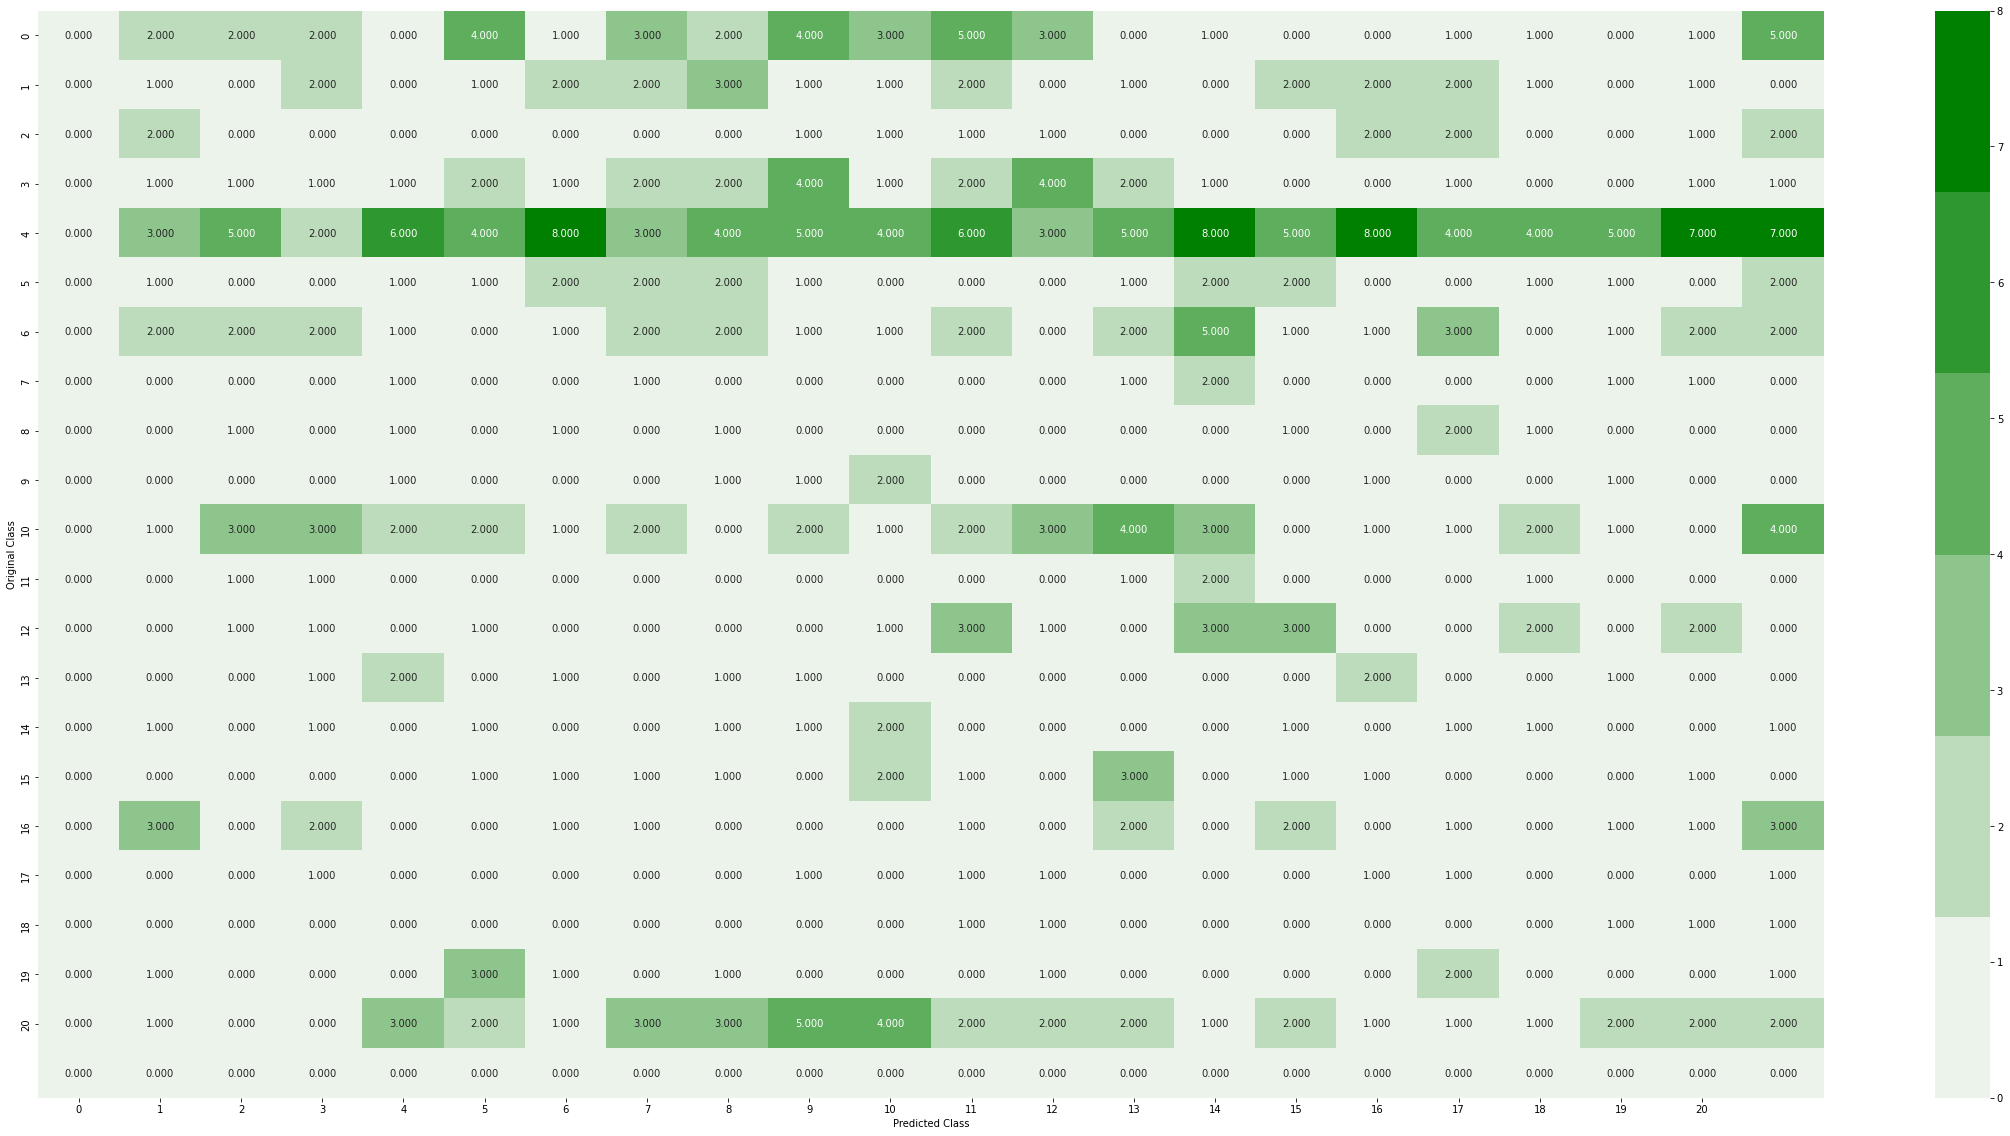

-------------------------------------------------- Precision matrix --------------------------------------------------


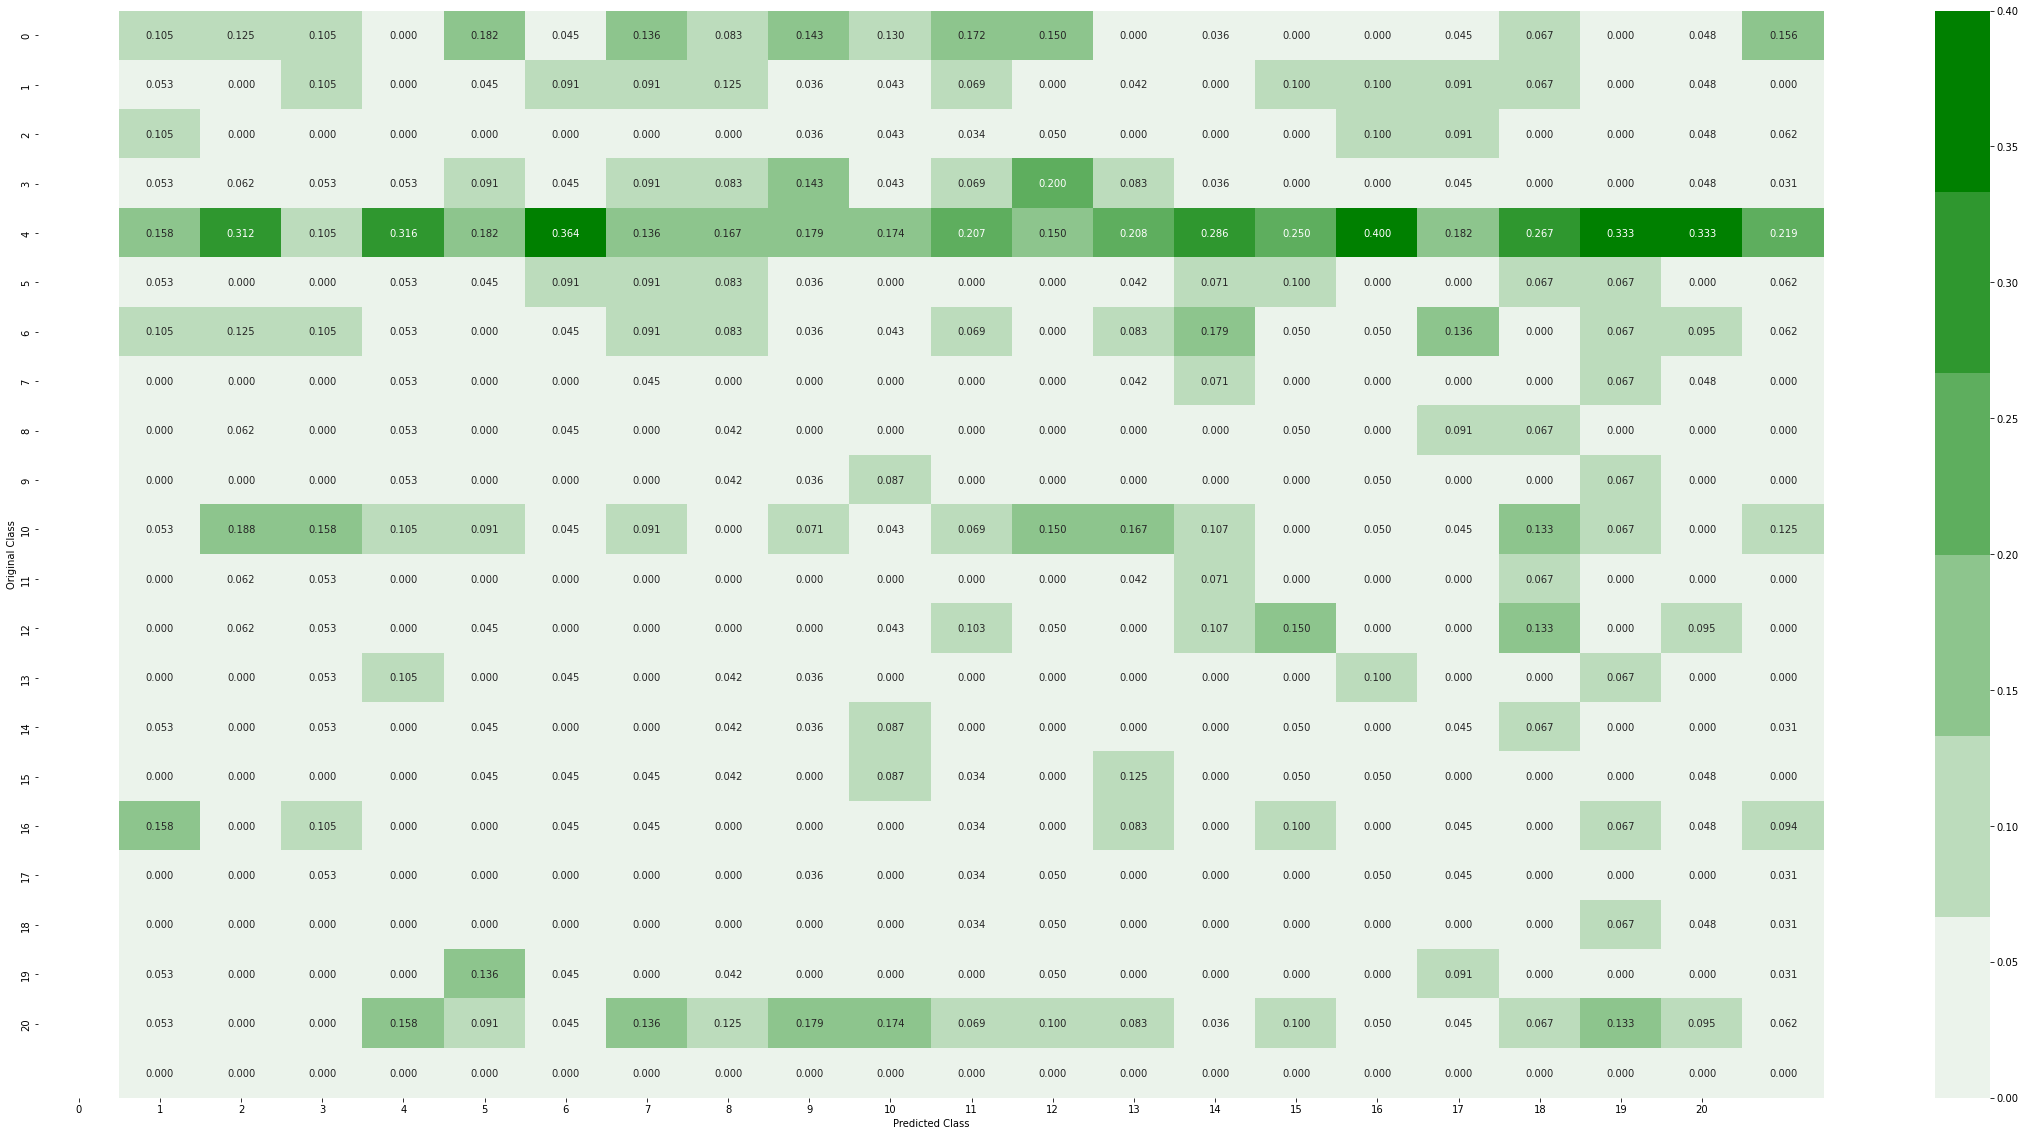

Sum of columns in precision matrix [nan  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


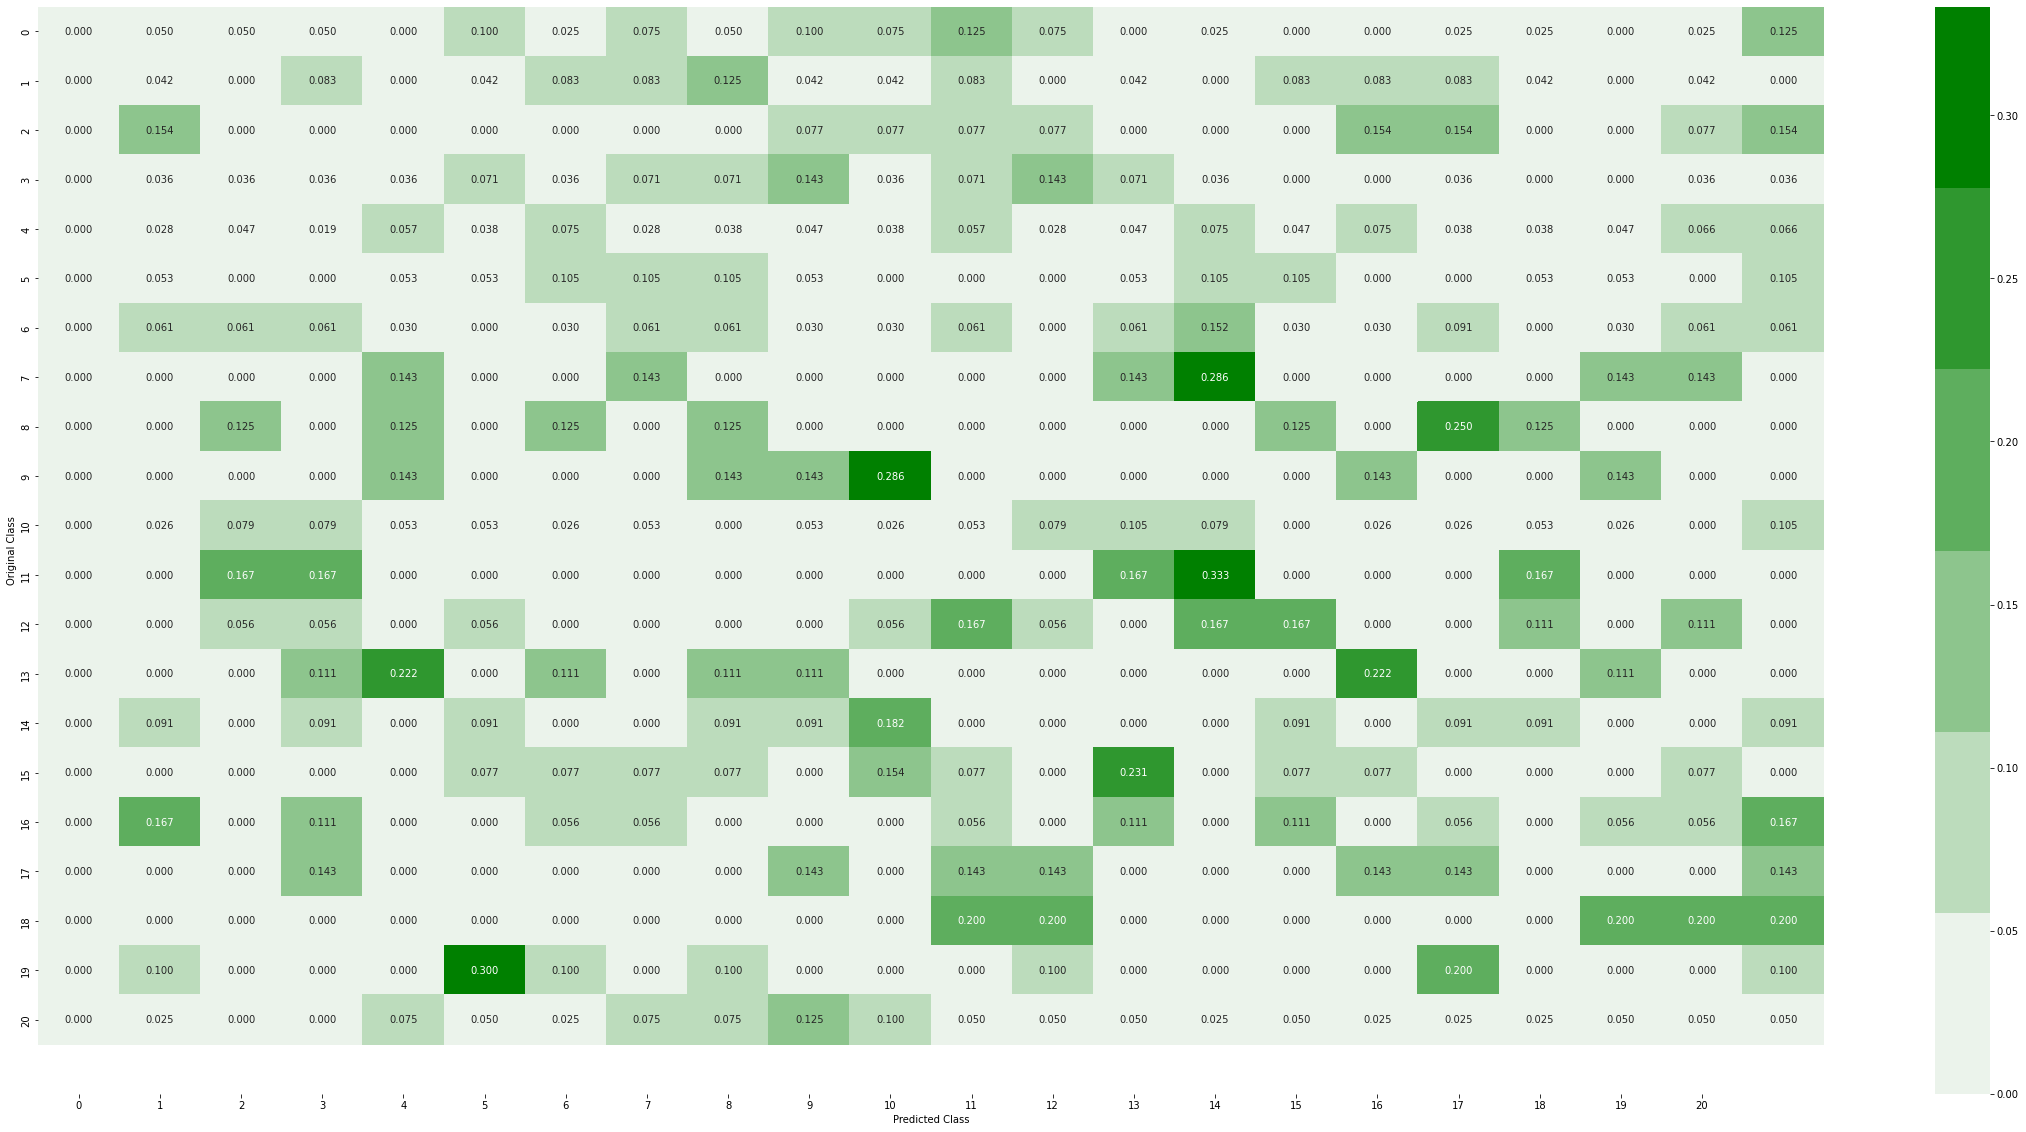

Sum of rows in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1. nan]


In [ ]:

test_data_len = x_test.shape[0]
cv_data_len = x_val.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,21))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,21)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_val,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,21))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,21)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

2.Random Forest Classifier

log_loss for c =  10 is 2.6513950139307685
log_loss for c =  50 is 2.6481910116948786
log_loss for c =  100 is 2.649064550732189
log_loss for c =  500 is 2.6502446371179462
log_loss for c =  1000 is 2.649919442441484
log_loss for c =  2000 is 2.6501568522805607
log_loss for c =  3000 is 2.6499156435613056


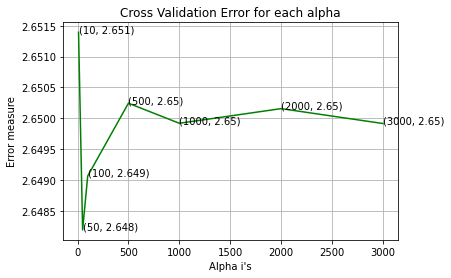

For values of best alpha =  50 The train log loss is: 2.1298239131767214
For values of best alpha =  50 The cross validation log loss is: 2.6481910116948786
For values of best alpha =  50 The test log loss is: 2.6655301209525186
Number of misclassified points  76.95652173913044
-------------------------------------------------- Confusion matrix --------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


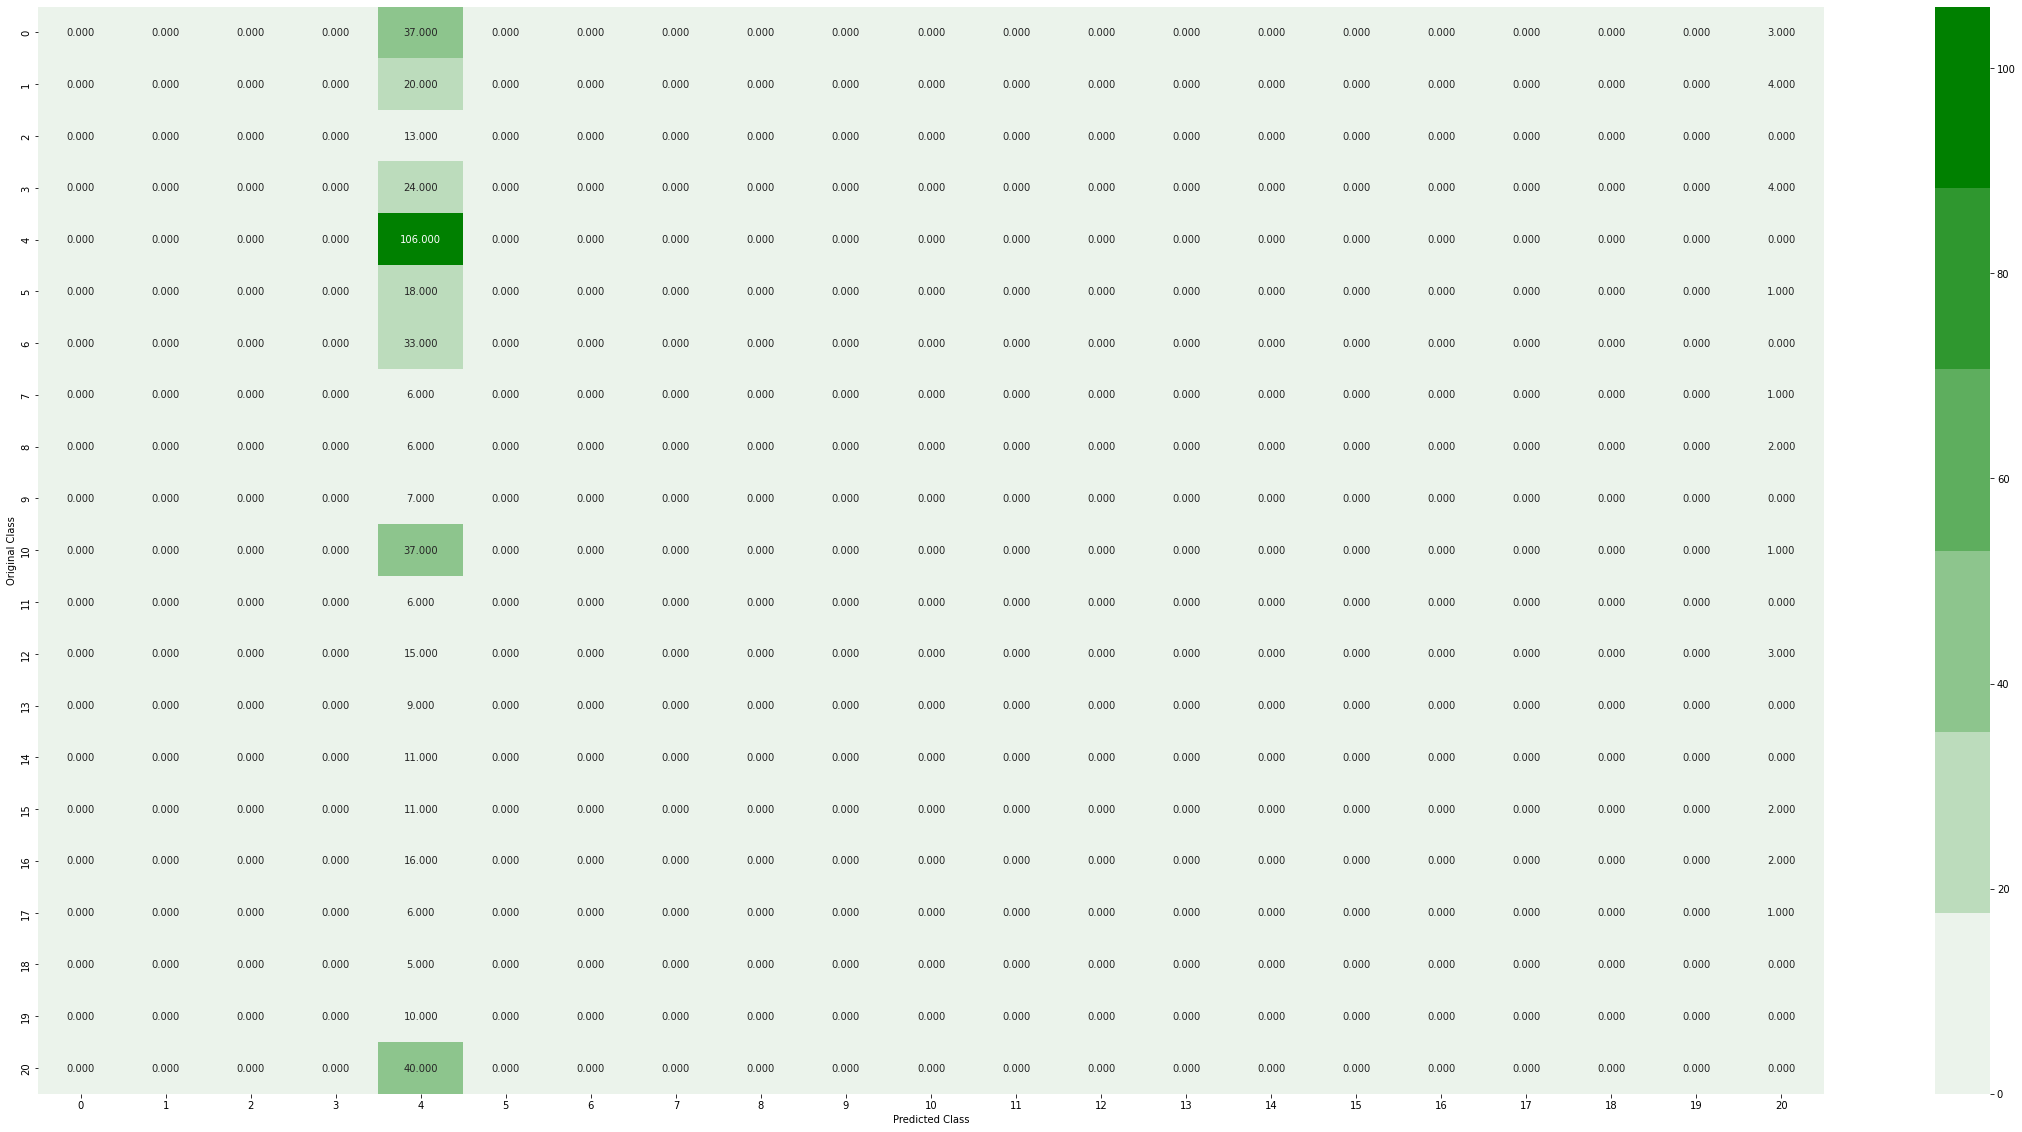

-------------------------------------------------- Precision matrix --------------------------------------------------


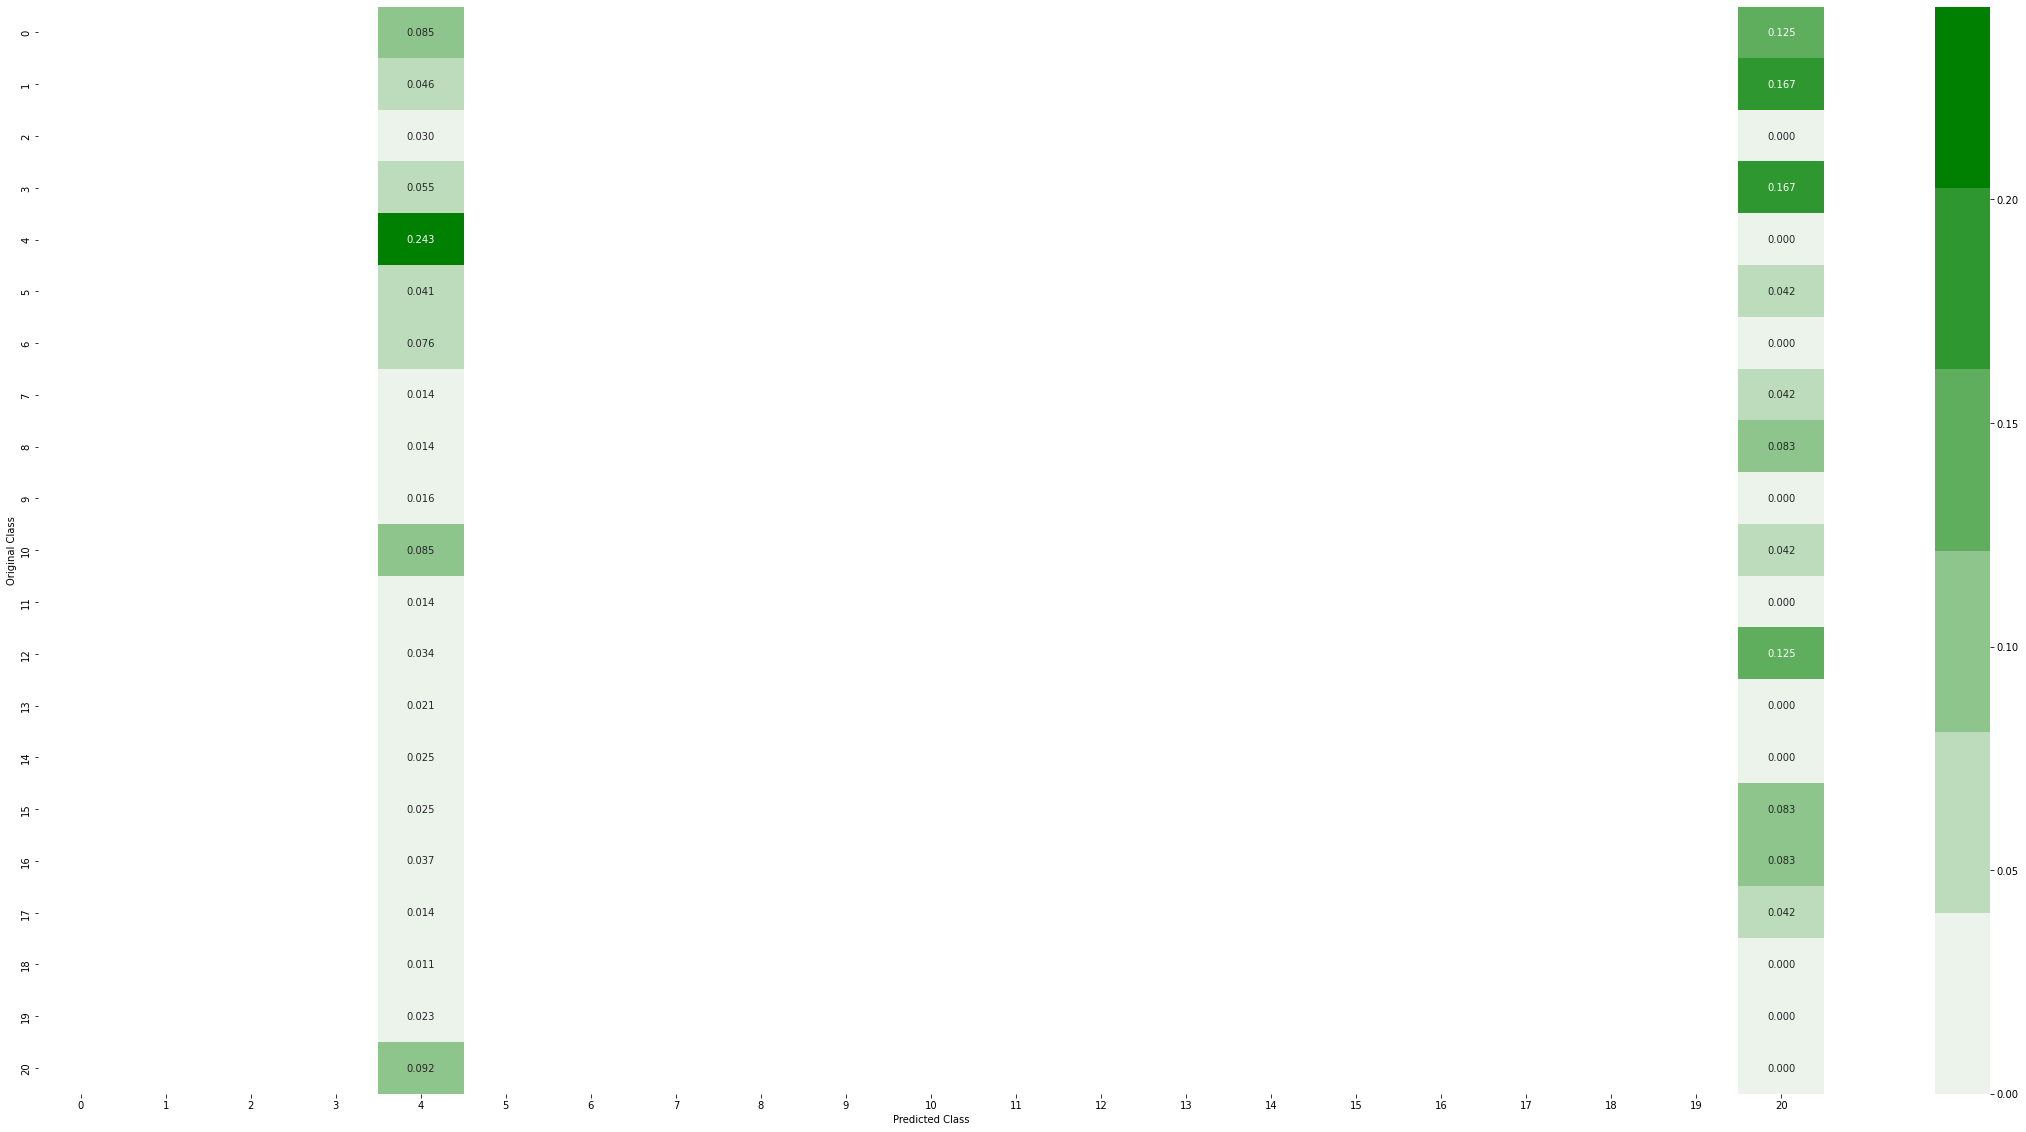

Sum of columns in precision matrix [nan nan nan nan  1. nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


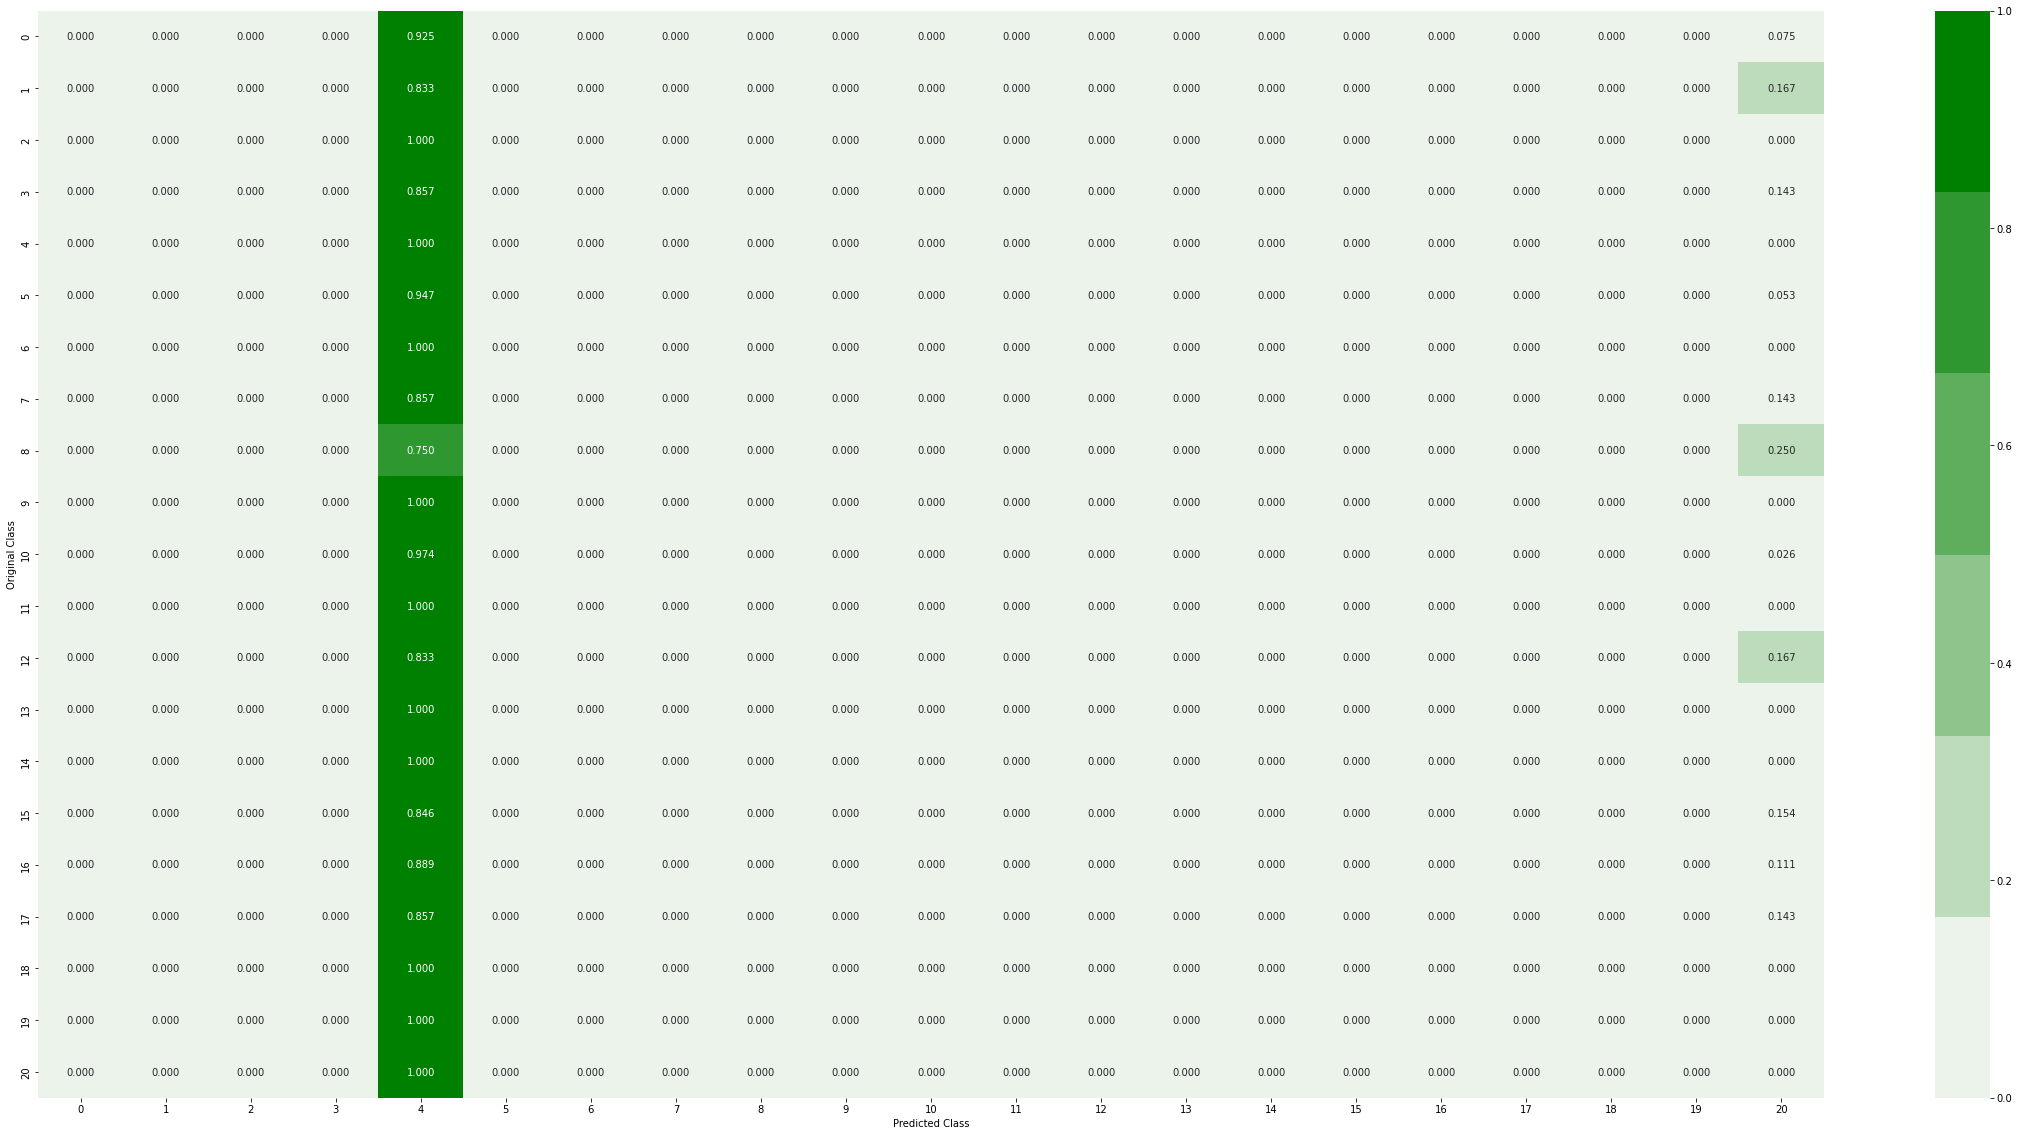

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(x_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_val)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(x_val)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y))
predict_y = sig_clf.predict_proba(x_test)

print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(x_test))

3.Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


log_loss for c =  1e-05 is 2.025415197017871
log_loss for c =  0.0001 is 2.0225706254617952
log_loss for c =  0.001 is 2.02597125664237
log_loss for c =  0.01 is 2.0346203904698266
log_loss for c =  0.1 is 2.031648785457602
log_loss for c =  1 is 2.029913099817335
log_loss for c =  10 is 2.0338377131425647
log_loss for c =  100 is 2.0340928971324375
log_loss for c =  1000 is 2.0358153797454843


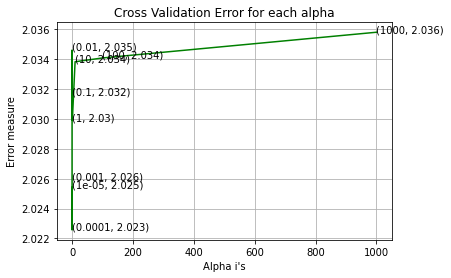

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


log loss for train data 1.9152845237437326
log loss for cv data 2.0225706254617952
log loss for test data 2.089812849464952
Number of misclassified points  74.34782608695653
-------------------------------------------------- Confusion matrix --------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


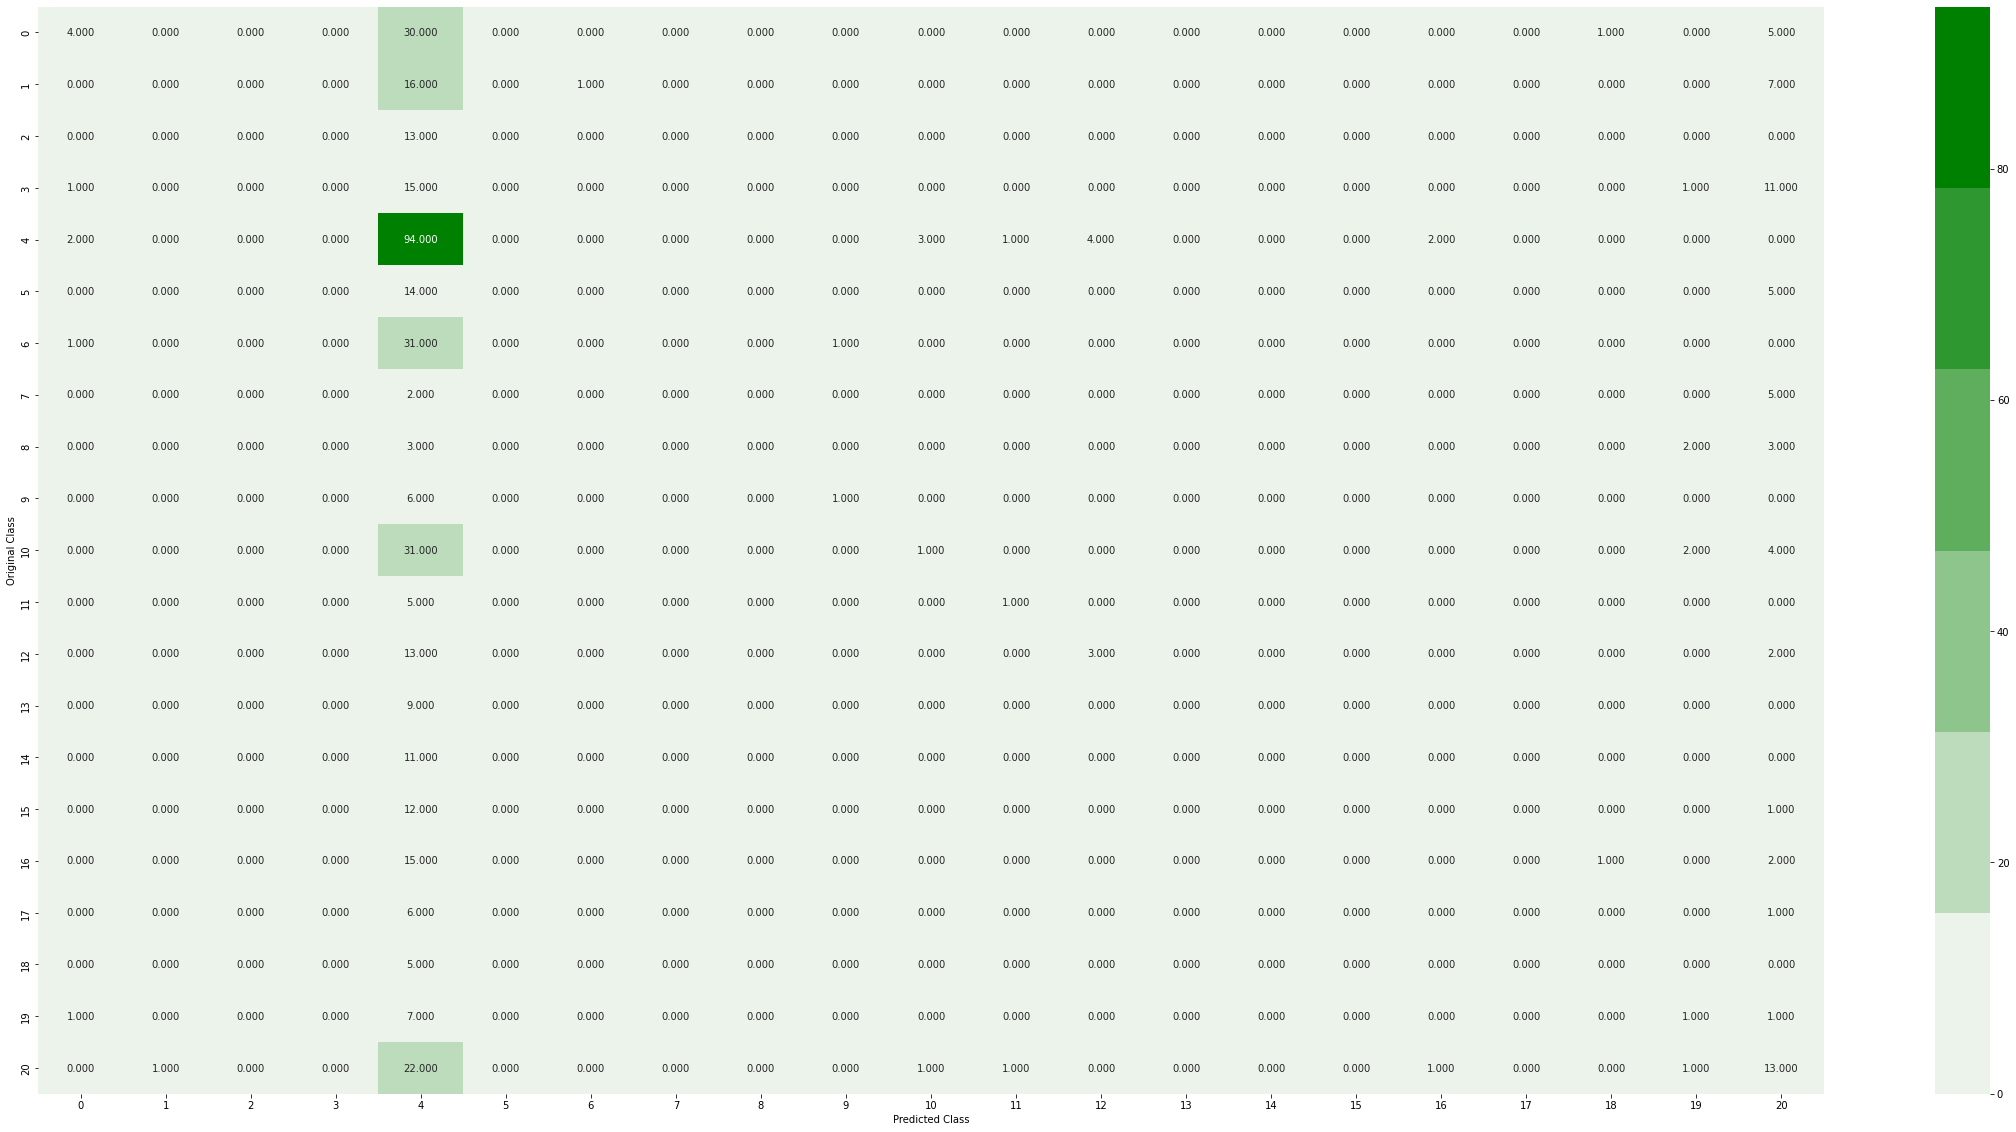

-------------------------------------------------- Precision matrix --------------------------------------------------


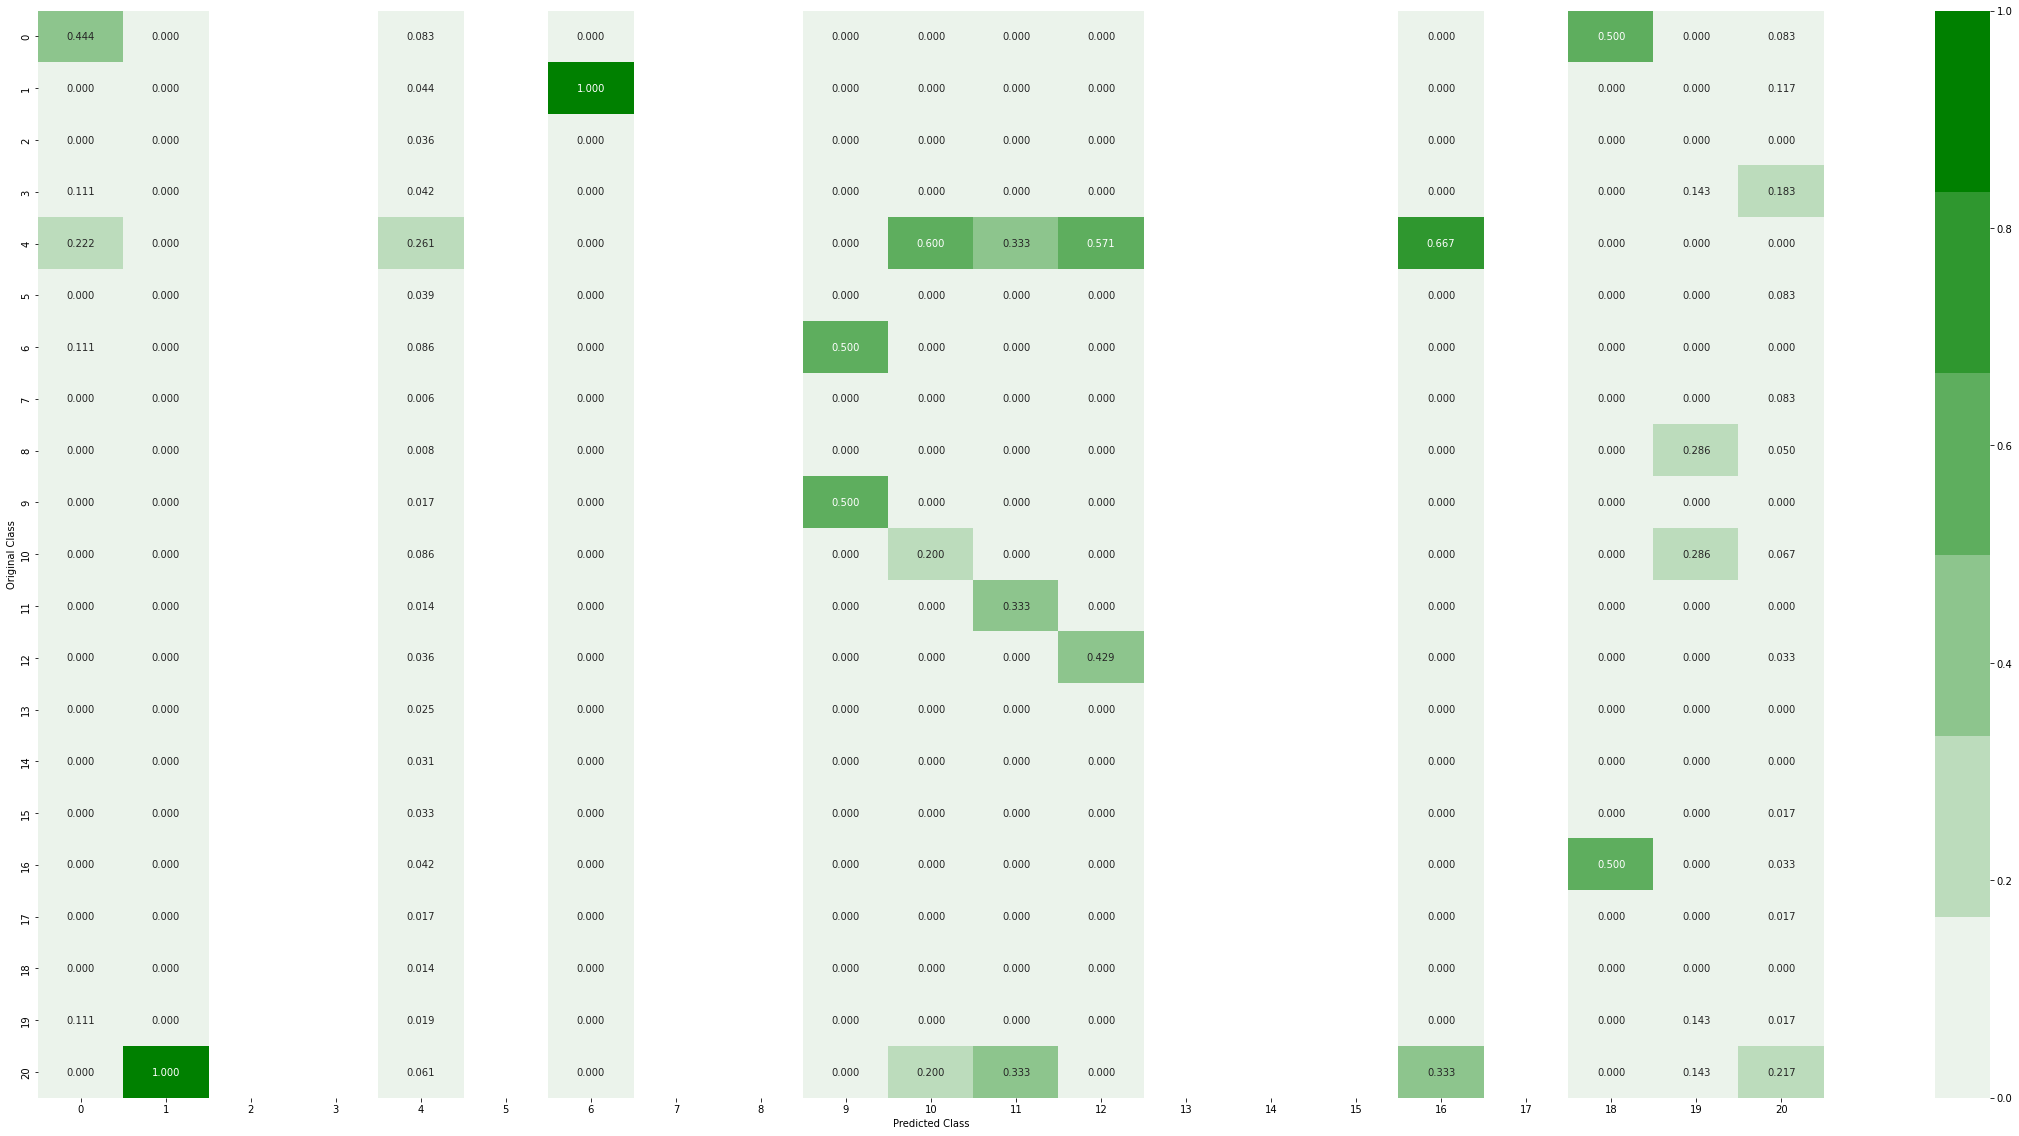

Sum of columns in precision matrix [ 1.  1. nan nan  1. nan  1. nan nan  1.  1.  1.  1. nan nan nan  1. nan
  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


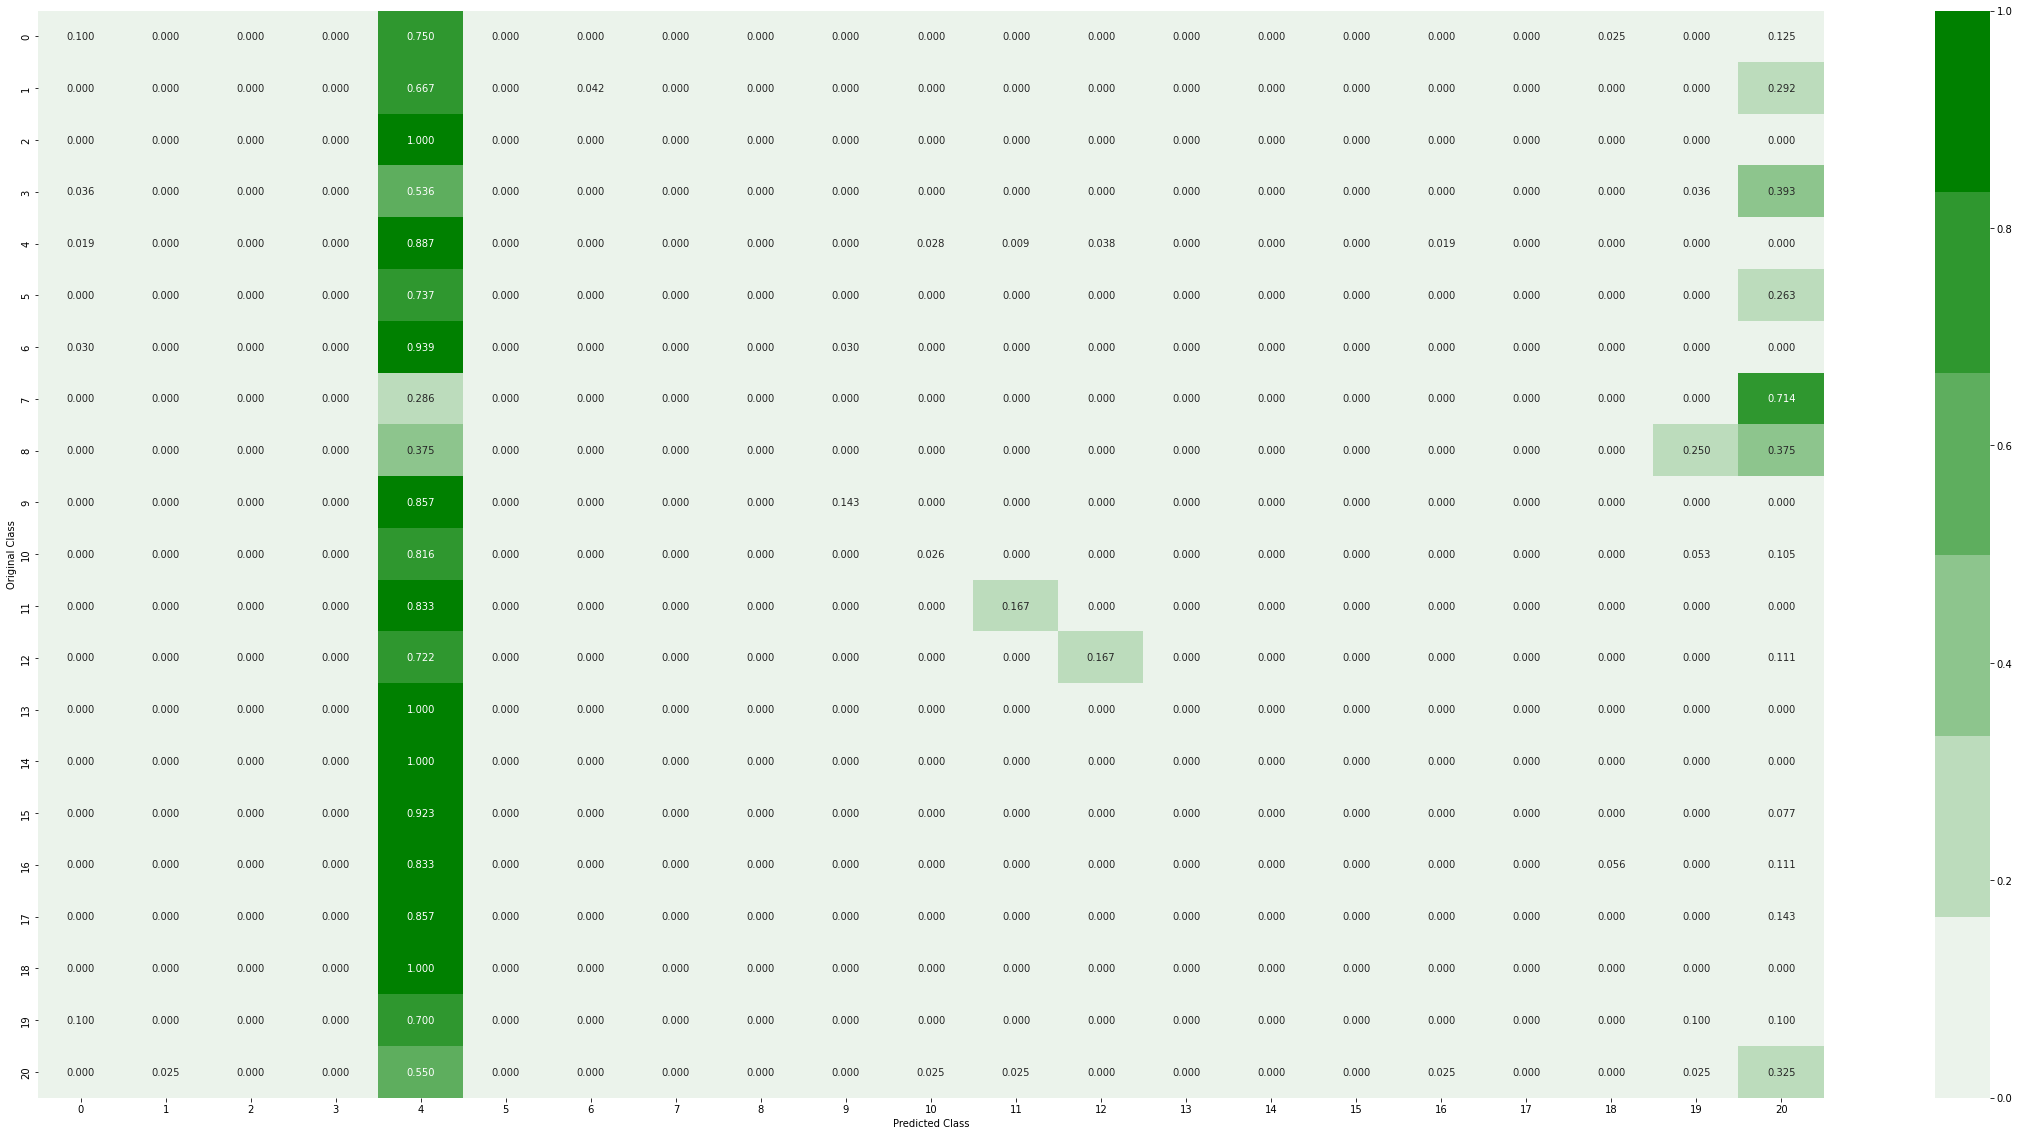

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(x_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_val)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(x_train, y_train)
pred_y=sig_clf.predict(x_test)

predict_y = sig_clf.predict_proba(x_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_val)
print ('log loss for cv data',log_loss(y_val, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
plot_confusion_matrix(y_test, sig_clf.predict(x_test))

XGB Classifier with hyperparameter tunning
find best params

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.1,0.2],
     'n_estimators':[1000,2000,3000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.3,0.5,1],
    'subsample':[0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=5,n_iter= 2)
random_cfl.fit(x_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=0.3;, score=0.158 total time=34.6min
[CV 2/5] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=0.3;, score=0.175 total time=34.2min
[CV 3/5] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=0.3;, score=0.206 total time=34.5min
[CV 4/5] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=0.3;, score=0.190 total time=34.4min
[CV 5/5] END colsample_bytree=1, learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=0.3;, score=0.164 total time=34.5min
[CV 1/5] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=1;, score=0.151 total time=37.9min
[CV 2/5] END colsample_bytree=0.5, learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=1;, score=0.174 total time=37.8min
[CV 3/5] END col

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_c...
                                           min_child_weight=None, missing=nan,
                                   

In [ ]:
print (random_cfl.best_params_)

{'subsample': 0.3, 'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1}


SGDClassifier find out best alpha

In [ ]:
from sklearn.linear_model import SGDClassifier
alpha = [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

#[10,50,100,500,1000,2000,3000]
cv_log_error_array = []
alpha_=[]
for i in alpha:
        clf = SGDClassifier(alpha=i, random_state=42)
        clf.fit(x_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(x_train, y_train)
        sig_clf_probs = sig_clf.predict_proba(x_val)
        cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        alpha_.append(i)
        
temp_df = pd.DataFrame(data={'alpha': np.round(alpha_),'cv_log_error': np.round(cv_log_error_array,5)})
temp_df.sort_values(by ='cv_log_error',ascending=True)

,alpha,cv_log_error
8,1000.0,1.98539
7,100.0,1.99544
6,10.0,1.99992
5,1.0,2.00156
4,0.0,2.67804
0,0.0,2.69314
1,0.0,2.69314
2,0.0,2.69314
3,0.0,2.69314


In [ ]:
best_estimator = temp_df.loc[temp_df['cv_log_error'] == temp_df['cv_log_error'].min(), 'alpha'].item()
best_alpha ='alpha=',str(best_estimator)
best_alpha

('alpha=', '1000.0')

RandomForestClassifier find out best n_estimators,max depth

In [ ]:
alpha = [10,50,100,500,1000,2000,3000]
max_depth = [5, 10]

cv_log_error_array = []
n_estimators=[]
depth=[]
for i in alpha:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(x_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(x_train, y_train)
        sig_clf_probs = sig_clf.predict_proba(x_val)
        cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        depth.append(j)
        n_estimators.append(i)
        
temp_df = pd.DataFrame(data={'n_estimators': np.round(n_estimators), 'max_depth': np.round(depth),'cv_log_error': np.round(cv_log_error_array,5)})
temp_df.sort_values(by ='cv_log_error',ascending=True)

,n_estimators,max_depth,cv_log_error
8,1000,5,2.09307
12,3000,5,2.09345
10,2000,5,2.09347
6,500,5,2.09355
4,100,5,2.10641
2,50,5,2.11079
0,10,5,2.17606
13,3000,10,2.50455
11,2000,10,2.50466
5,100,10,2.50546


In [ ]:
best_estimator = temp_df.loc[temp_df['cv_log_error'] == temp_df['cv_log_error'].min(), 'n_estimators'].item()
best_depth = temp_df.loc[temp_df['cv_log_error'] == temp_df['cv_log_error'].min(), 'max_depth'].item()
best_alpha ='n_estimators=',str(best_estimator),'max depth=',str(best_depth)
best_alpha

('n_estimators=', '1000', 'max depth=', '5')

In [ ]:
pip install mlrose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=b26609e0d5e6677118cbdef9082d5d31f7b3d0e6a6b52fb70fe2b369941cd16f
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [ ]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

In [ ]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import SGDClassifier

Stacking Classifier with AdaBoostClassifier , SGDClassifier with best alpha= 1000 , and calculated best n_estimators and max_depth of RandomForestClassifier



In [ ]:
#AdaBoost
clf1 = AdaBoostClassifier(base_estimator=LinearSVC(random_state=0), random_state=0, algorithm='SAMME')
clf1.fit(x_train, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")
#SGD
clf2 = SGDClassifier(alpha=1000, class_weight='balanced',  penalty='l2', loss='log', random_state=42)
clf2.fit(x_train, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")
# Random Forest
clf3 = RandomForestClassifier(n_estimators = 1000,random_state=42,n_jobs=-1,max_depth= 5)
clf3.fit(x_train, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(x_train, y_train)
sig_clf2.fit(x_train, y_train)
sig_clf3.fit(x_train, y_train)

alpha =[100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(x_train, y_train)
    cv_log_error_array.append(log_loss(y_val, sclf.predict_proba(x_val)))   
temp_df = pd.DataFrame(data={'alpha': np.round(alpha,5), 'cv_log_error': np.round(cv_log_error_array,3)})
temp_df.sort_values(by ='cv_log_error',ascending=True)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

,alpha,cv_log_error
0,100,2.389
1,500,2.443
3,2000,2.541
2,1000,2.542
4,3000,2.548


log_loss for c =  100 is 2.38899066846895
log_loss for c =  500 is 2.4426391733728763
log_loss for c =  1000 is 2.5418517537307745
log_loss for c =  2000 is 2.5408902662538737
log_loss for c =  3000 is 2.5476492128610637


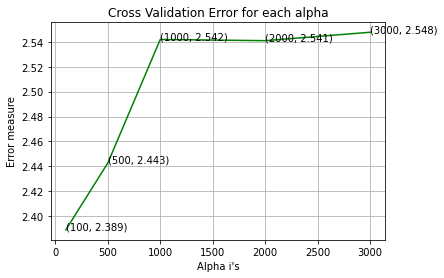

In [ ]:
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  100 The train log loss is: 0.9416466804691053
For values of best alpha =  100 The cross validation log loss is: 2.5476492128610637
For values of best alpha =  100 The test log loss is: 2.4748086763804604
Number of misclassified points  73.47826086956522
-------------------------------------------------- Confusion matrix --------------------------------------------------


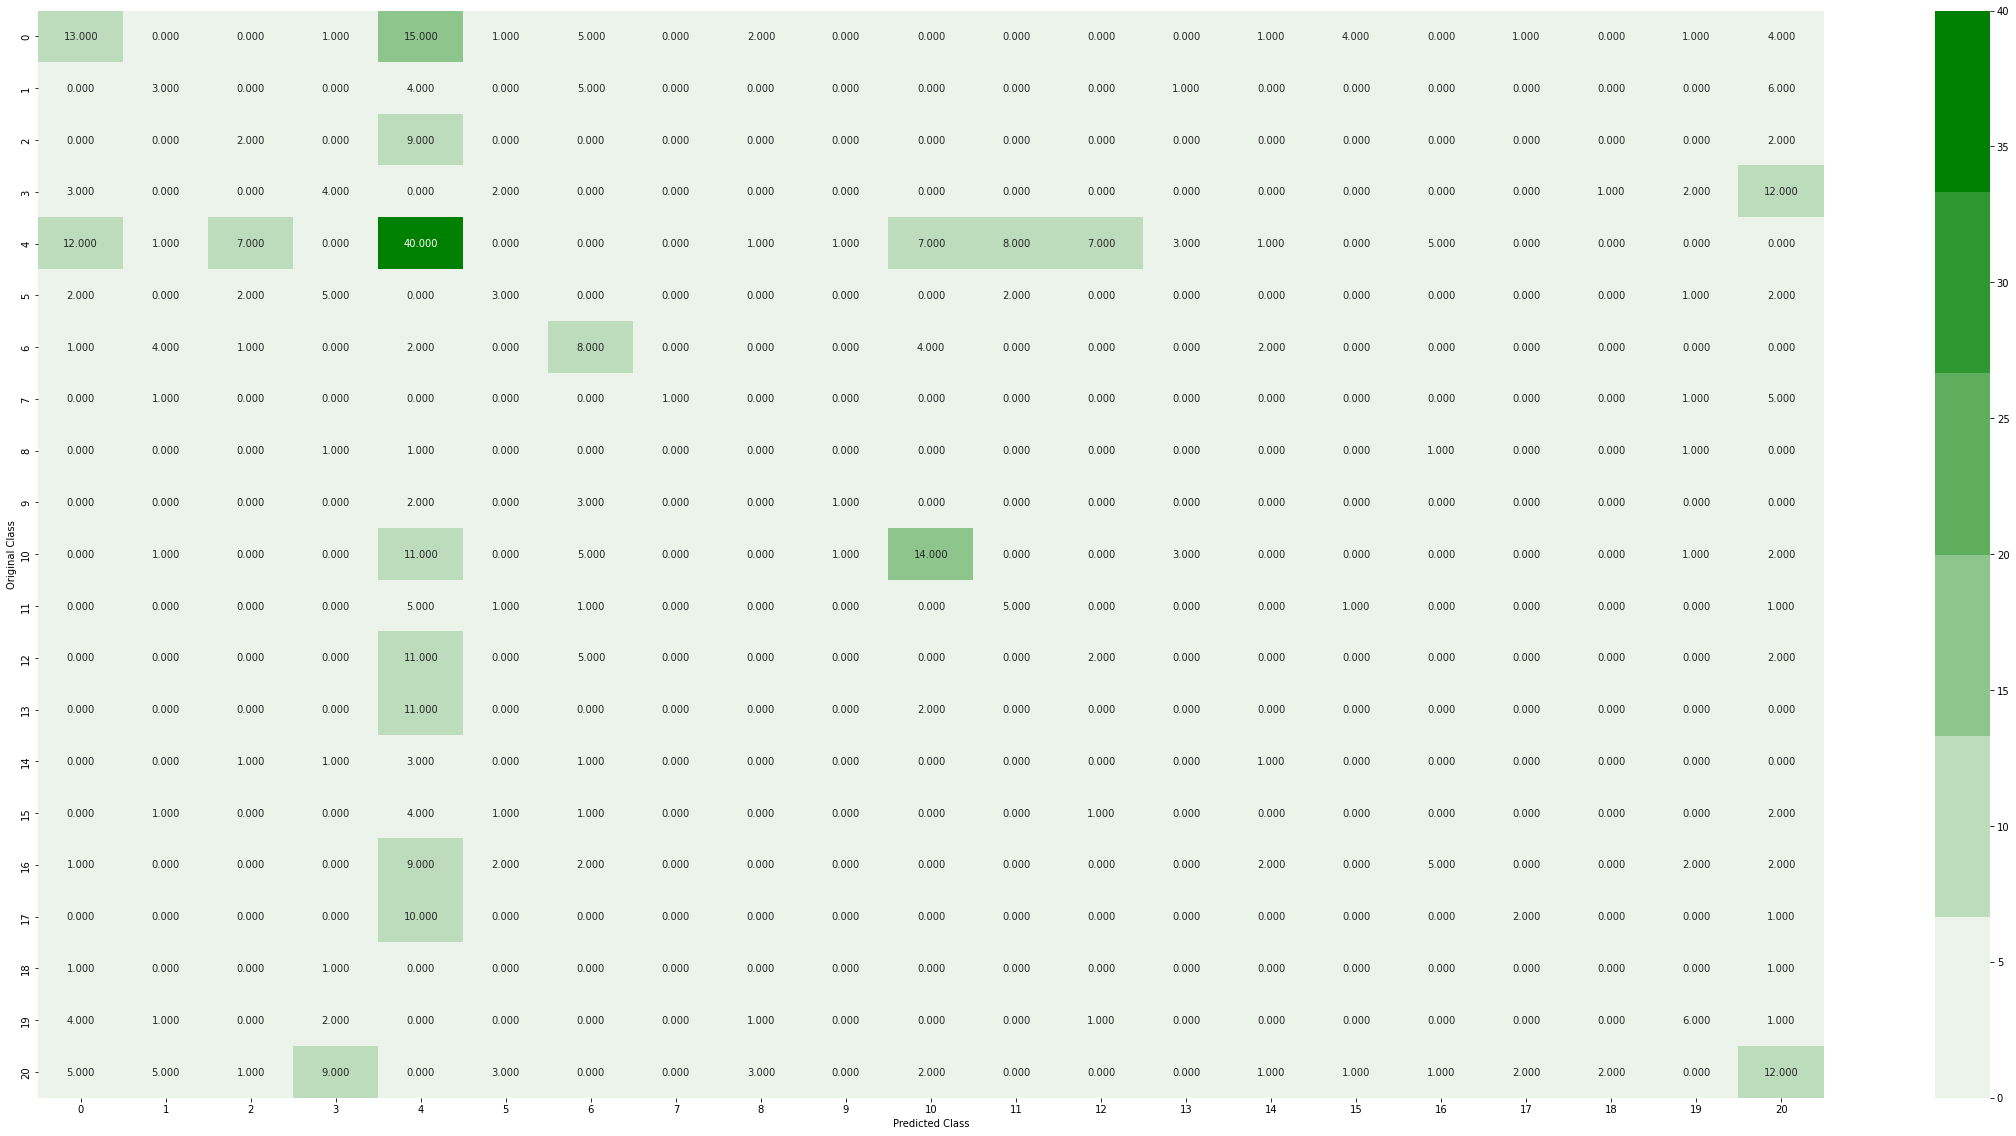

-------------------------------------------------- Precision matrix --------------------------------------------------


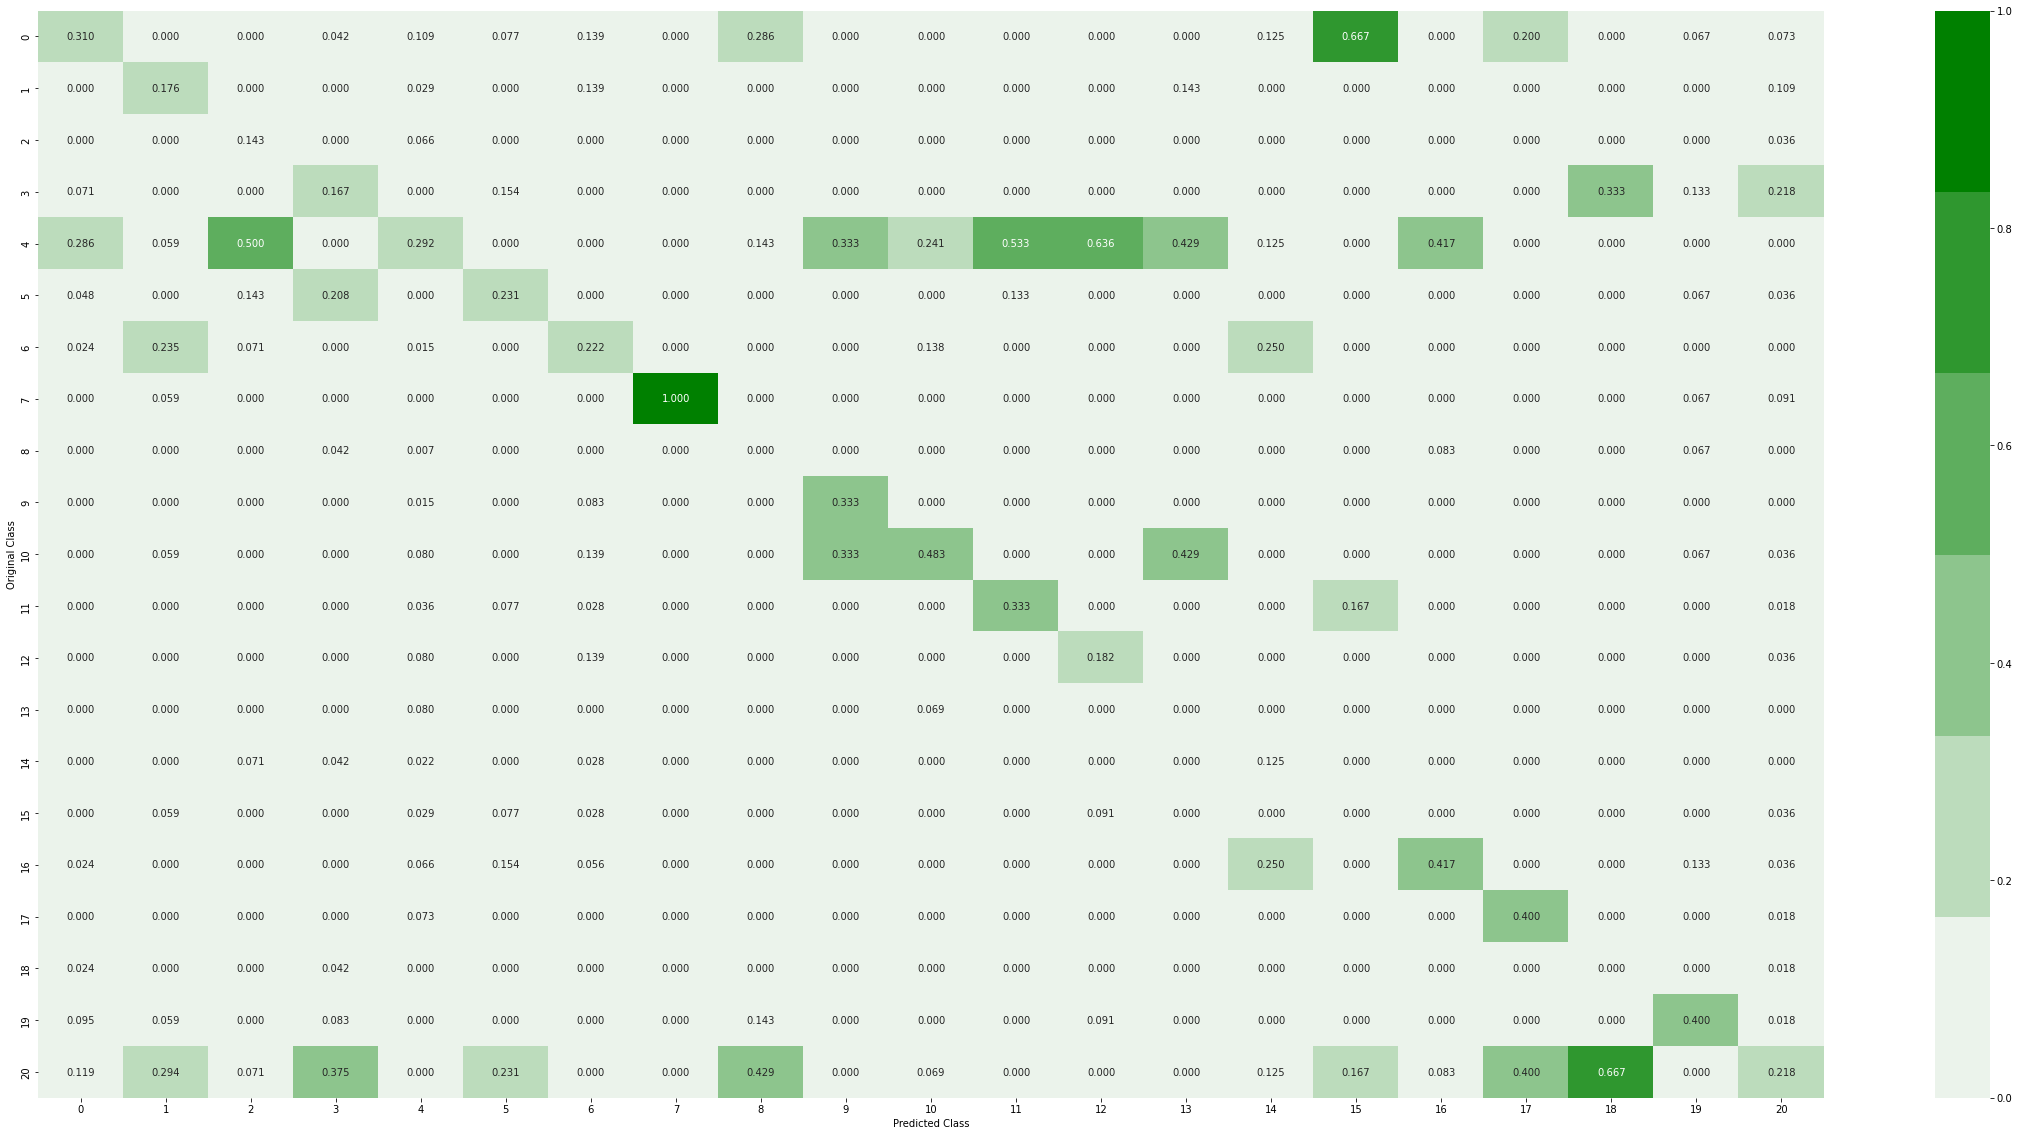

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


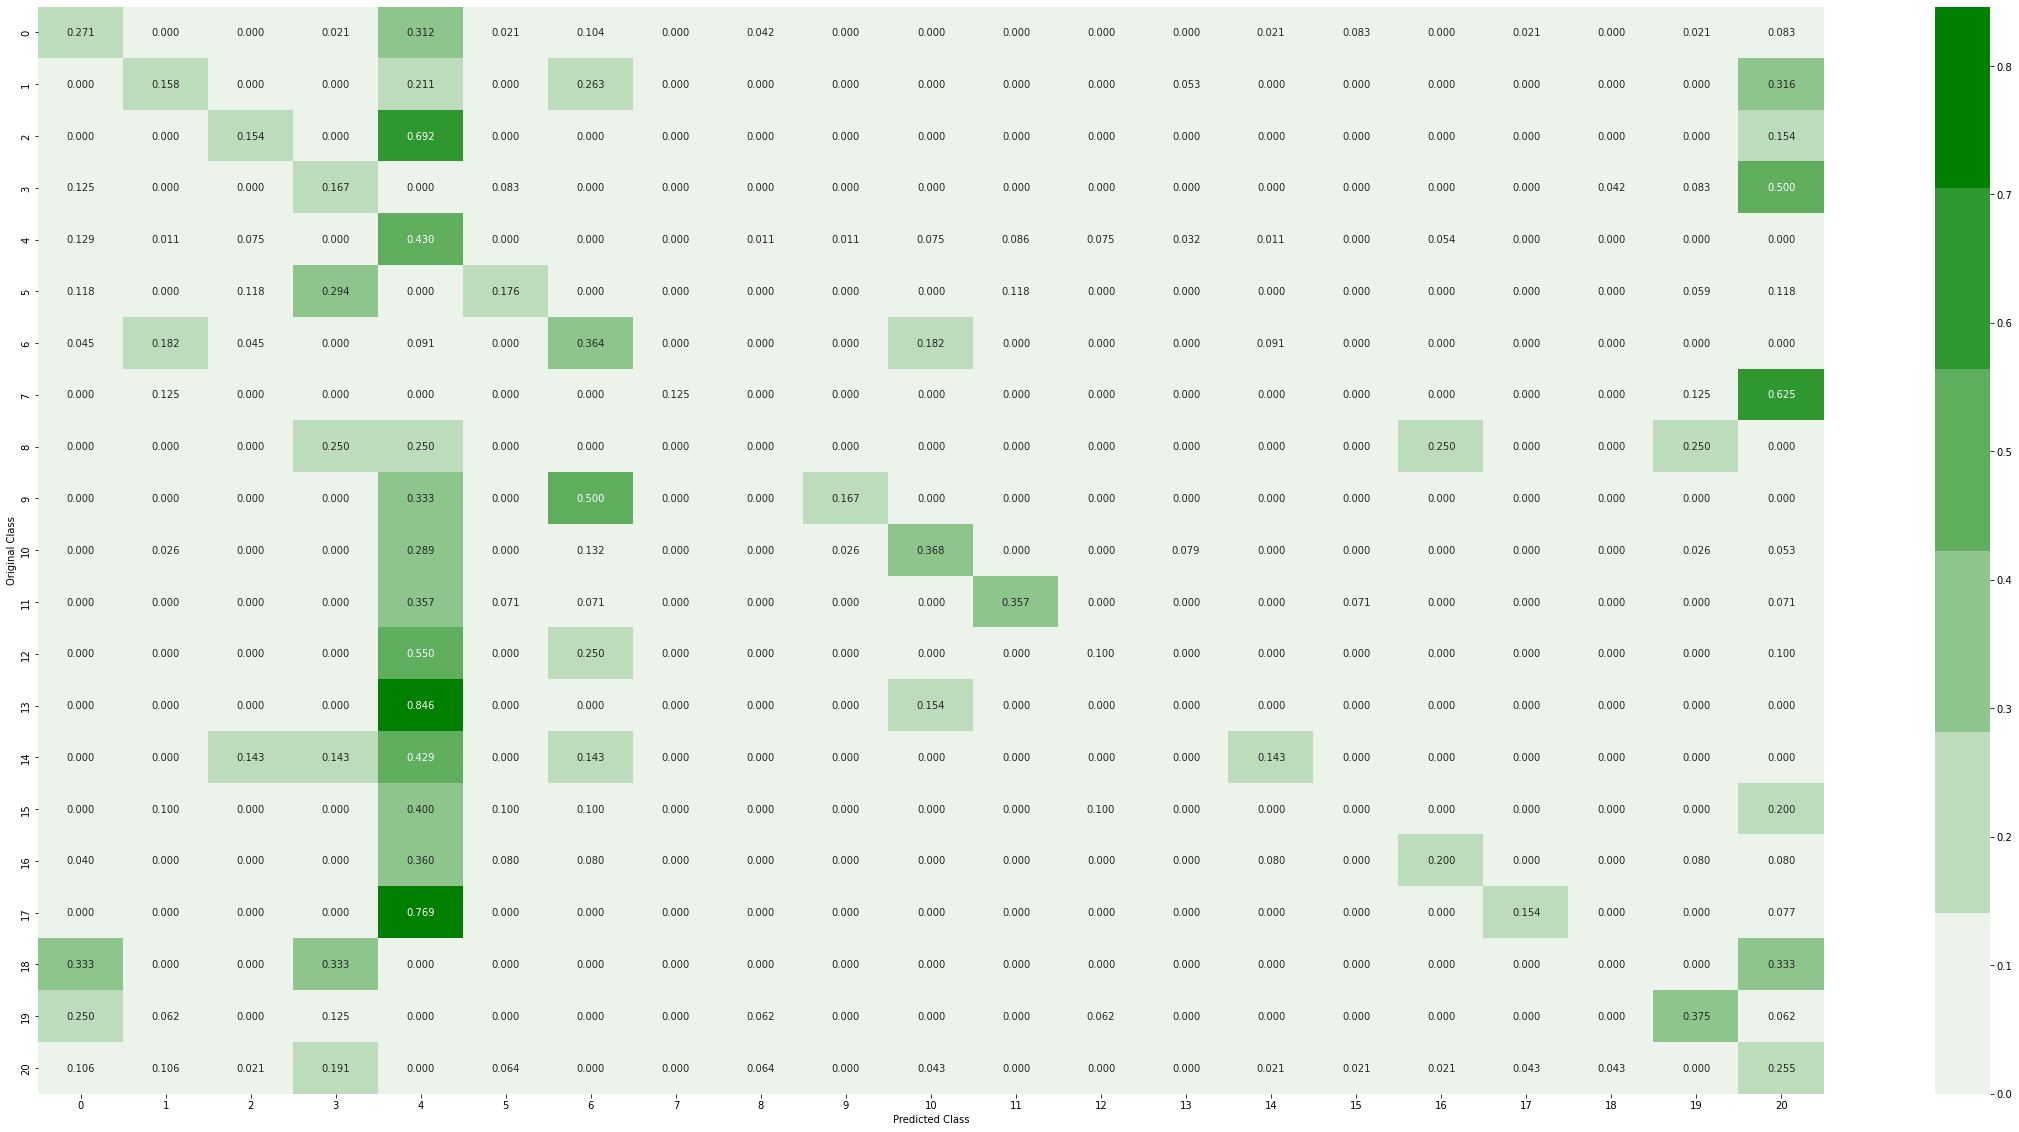

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
predict_y = sclf.predict_proba(x_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sclf.predict_proba(x_val)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y))
predict_y = sclf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test,sclf.predict(x_test))

In [ ]:
alpha = [10,50,100,500,1000,2000,3000]
max_depth = [5, 10]

cv_log_error_array = []
n_estimators=[]
depth=[]
for i in alpha:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(x_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(x_train, y_train)
        sig_clf_probs = sig_clf.predict_proba(x_val)
        cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        depth.append(j)
        n_estimators.append(i)
        
temp_df = pd.DataFrame(data={'n_estimators': np.round(n_estimators), 'max_depth': np.round(depth),'cv_log_error': np.round(cv_log_error_array,5)})
temp_df.sort_values(by ='cv_log_error',ascending=True)

{'subsample': 0.3, 'n_estimators': 2000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1}

Stacking Classifier with XGBClassifier, SGDClassifier ,RandomForestClassifier

with 5 parameter of alpha take more than 5 hrs

In [ ]:
#XGBClassifier
clf1 = XGBClassifier(subsample =  0.3, n_estimators =  2000, max_depth =  5, learning_rate = 0.01, colsample_bytree = 1)
clf1.fit(x_train, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")
sig_clf1.fit(x_train, y_train)
#SGD
clf2 = SGDClassifier(alpha=1000, class_weight='balanced',  penalty='l2', loss='log', random_state=42)
clf2.fit(x_train, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")
# Random Forest
clf3 = RandomForestClassifier(n_estimators = 1000,random_state=42,n_jobs=-1,max_depth= 5)
clf3.fit(x_train, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")


sig_clf2.fit(x_train, y_train)
sig_clf3.fit(x_train, y_train)



CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=5,
                                                             n_estimators=1000,
                                                             n_jobs=-1,
                                                             random_state=42))

In [ ]:
alpha =[1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(x_train, y_train)
    cv_log_error_array.append(log_loss(y_val, sclf.predict_proba(x_val)))   
temp_df = pd.DataFrame(data={'alpha': np.round(alpha,5), 'cv_log_error': np.round(cv_log_error_array,3)})
temp_df.sort_values(by ='cv_log_error',ascending=True)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,alpha,cv_log_error
0,1000,4.094
1,2000,4.108
2,3000,4.397


log_loss for c =  1000 is 4.09396316316847
log_loss for c =  2000 is 4.108284917928079
log_loss for c =  3000 is 4.397291442916204


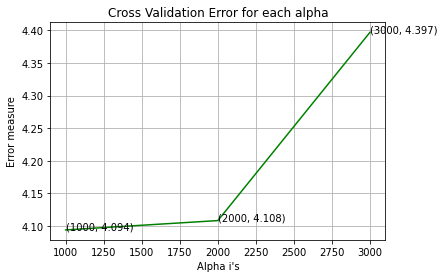

In [ ]:
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  1000 The train log loss is: 0.8338220296602793
For values of best alpha =  1000 The cross validation log loss is: 4.397291442916204
For values of best alpha =  1000 The test log loss is: 4.510082436009136
Number of misclassified points  85.43478260869564
-------------------------------------------------- Confusion matrix --------------------------------------------------


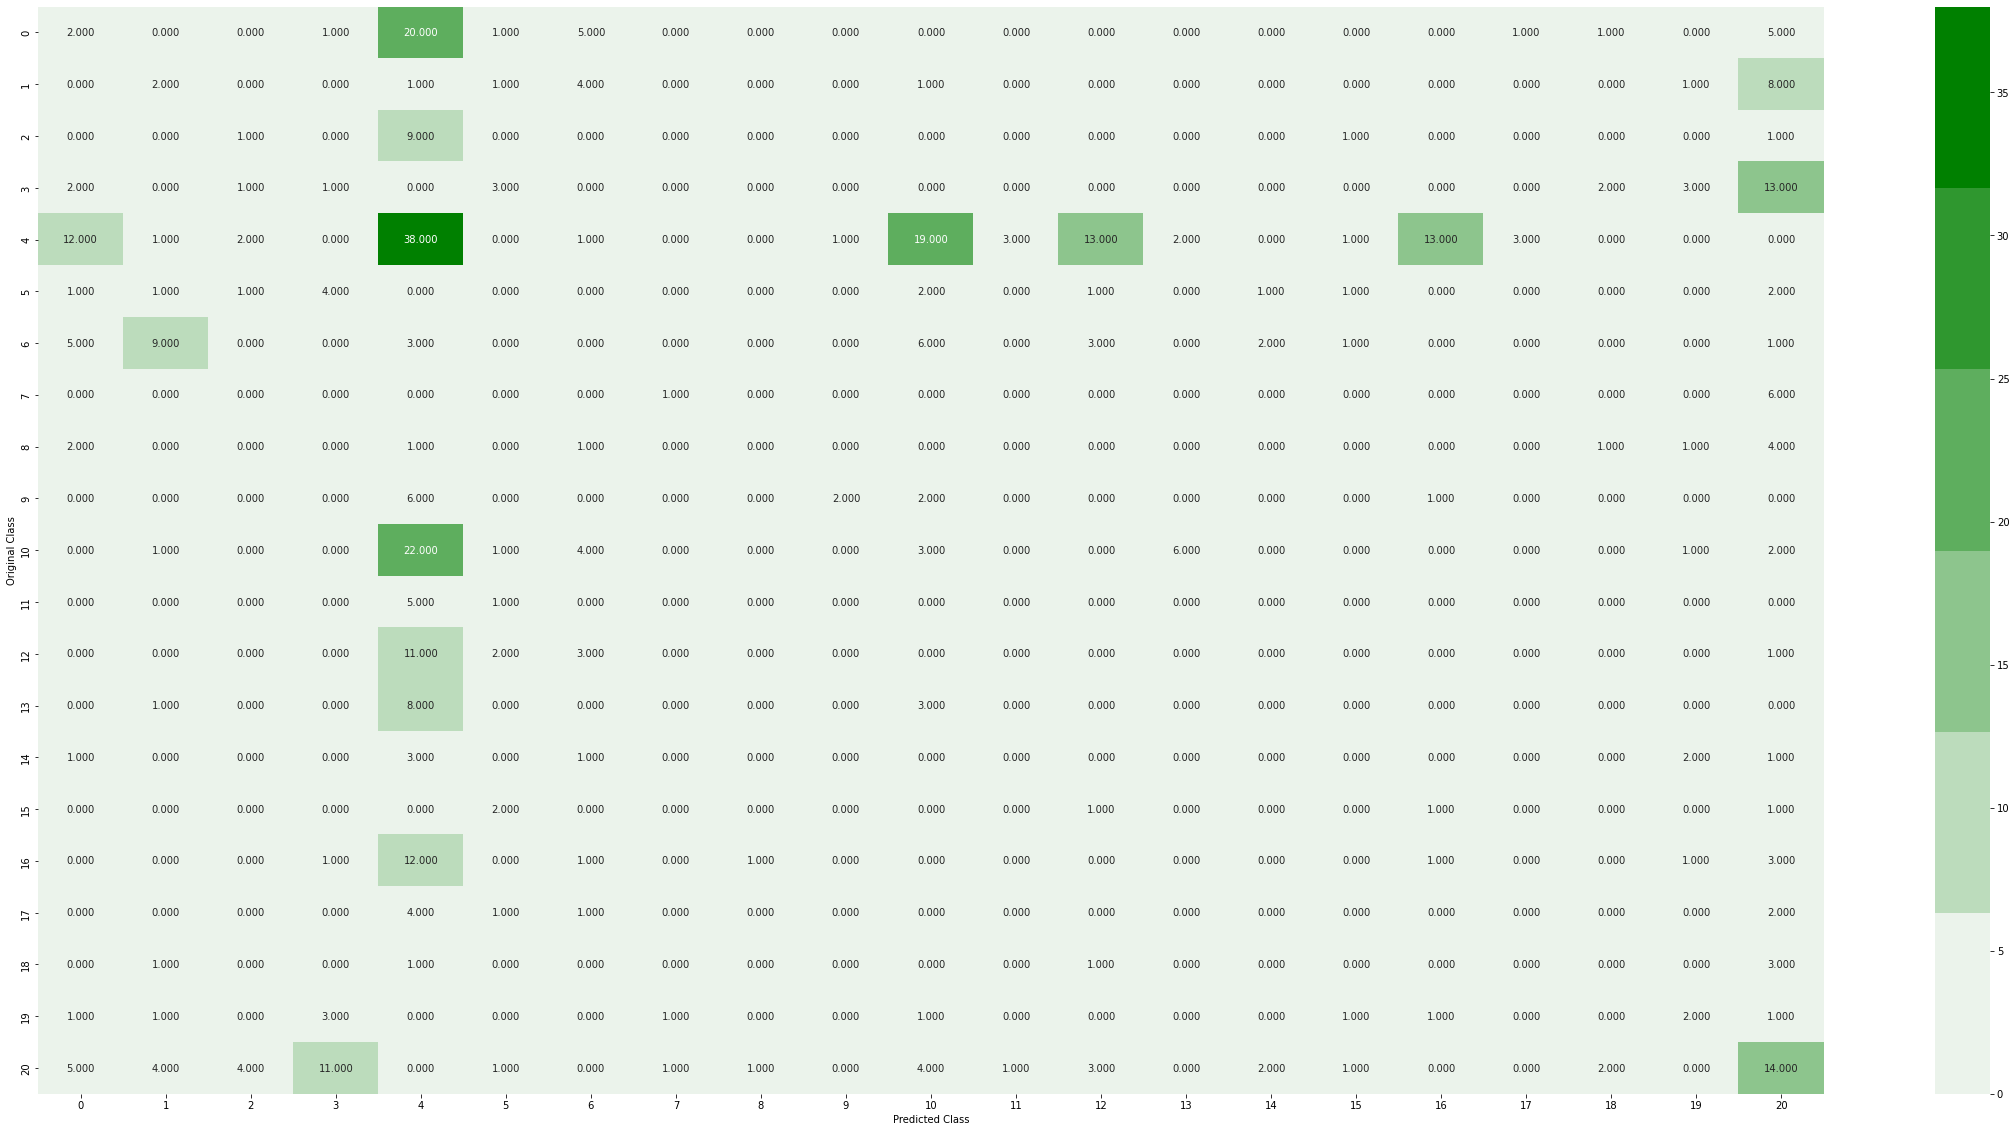

-------------------------------------------------- Precision matrix --------------------------------------------------


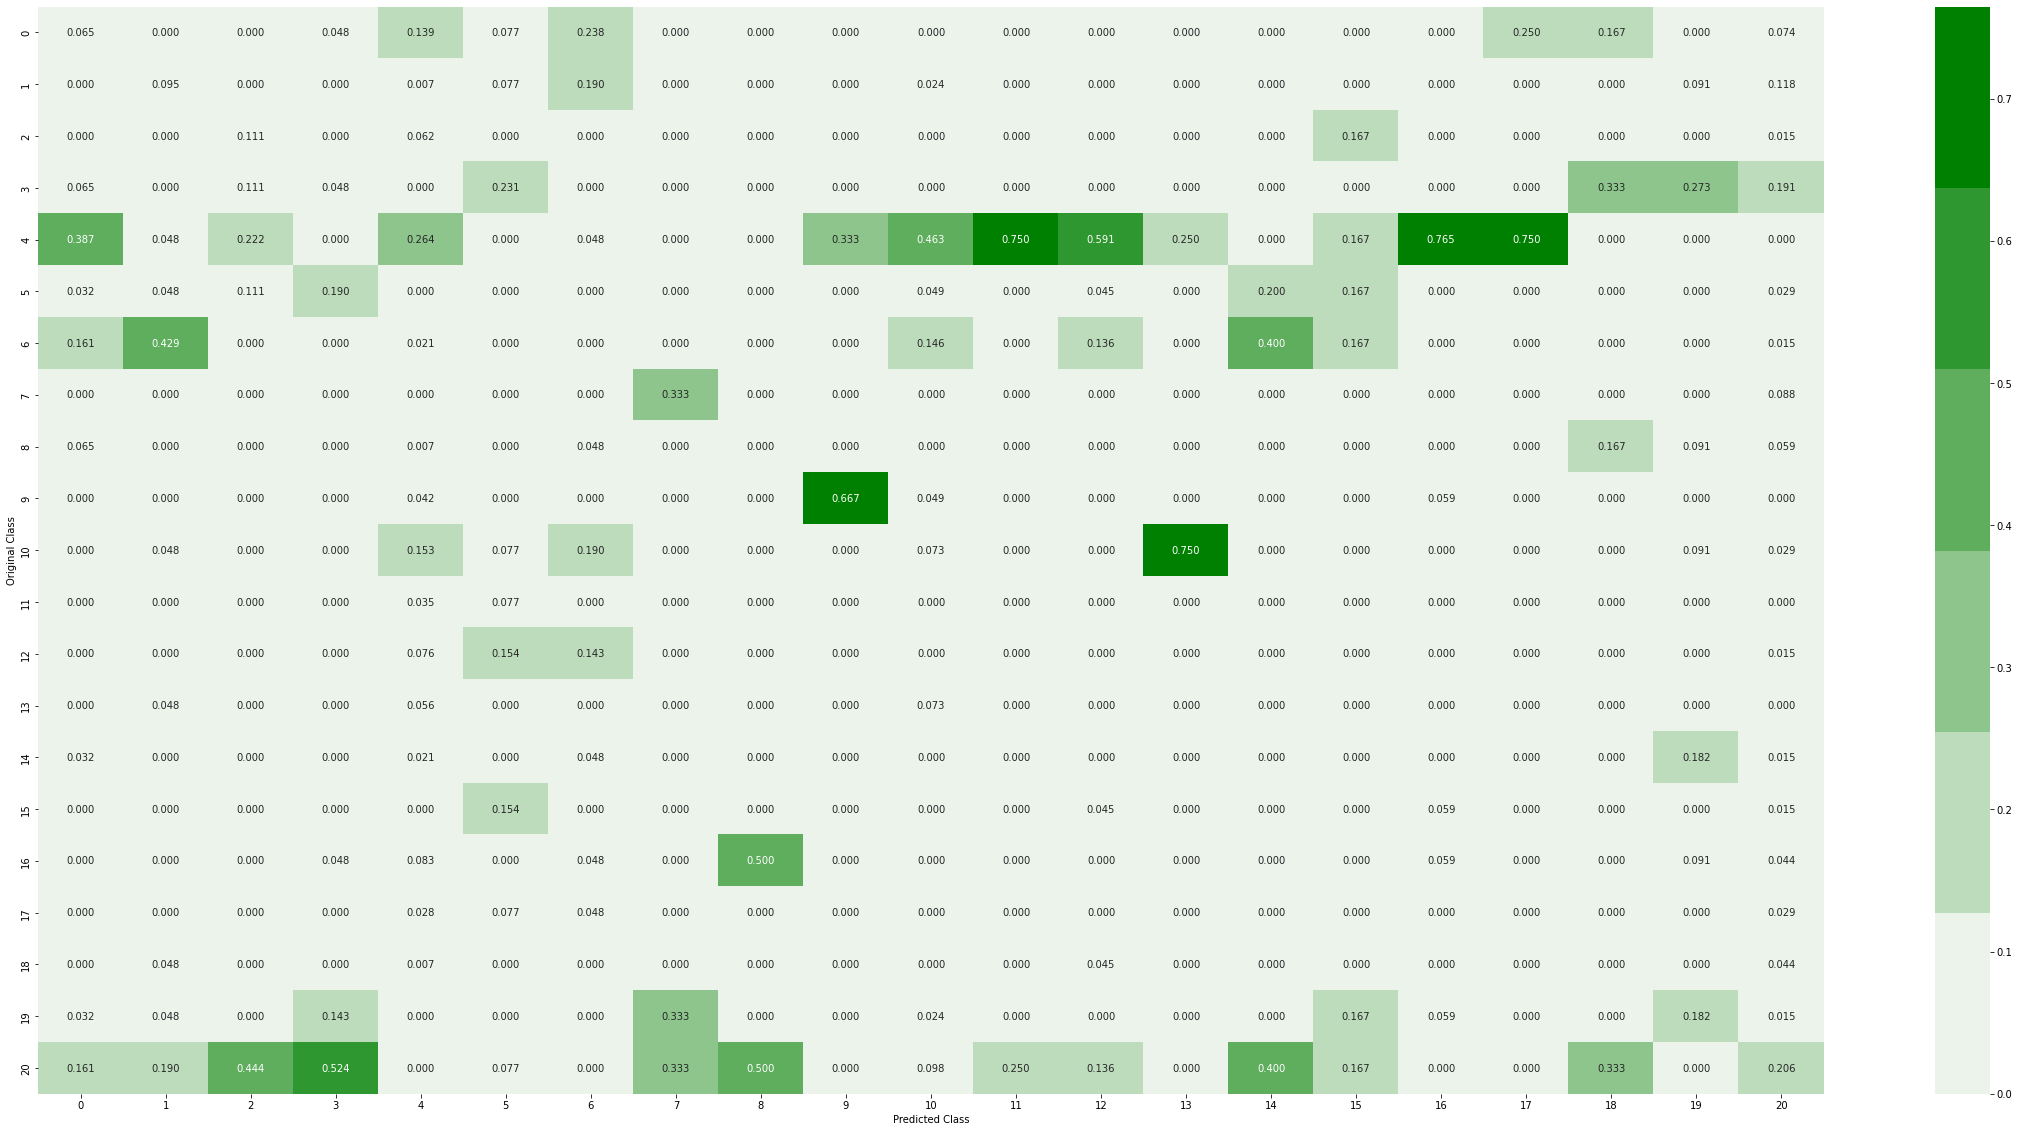

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


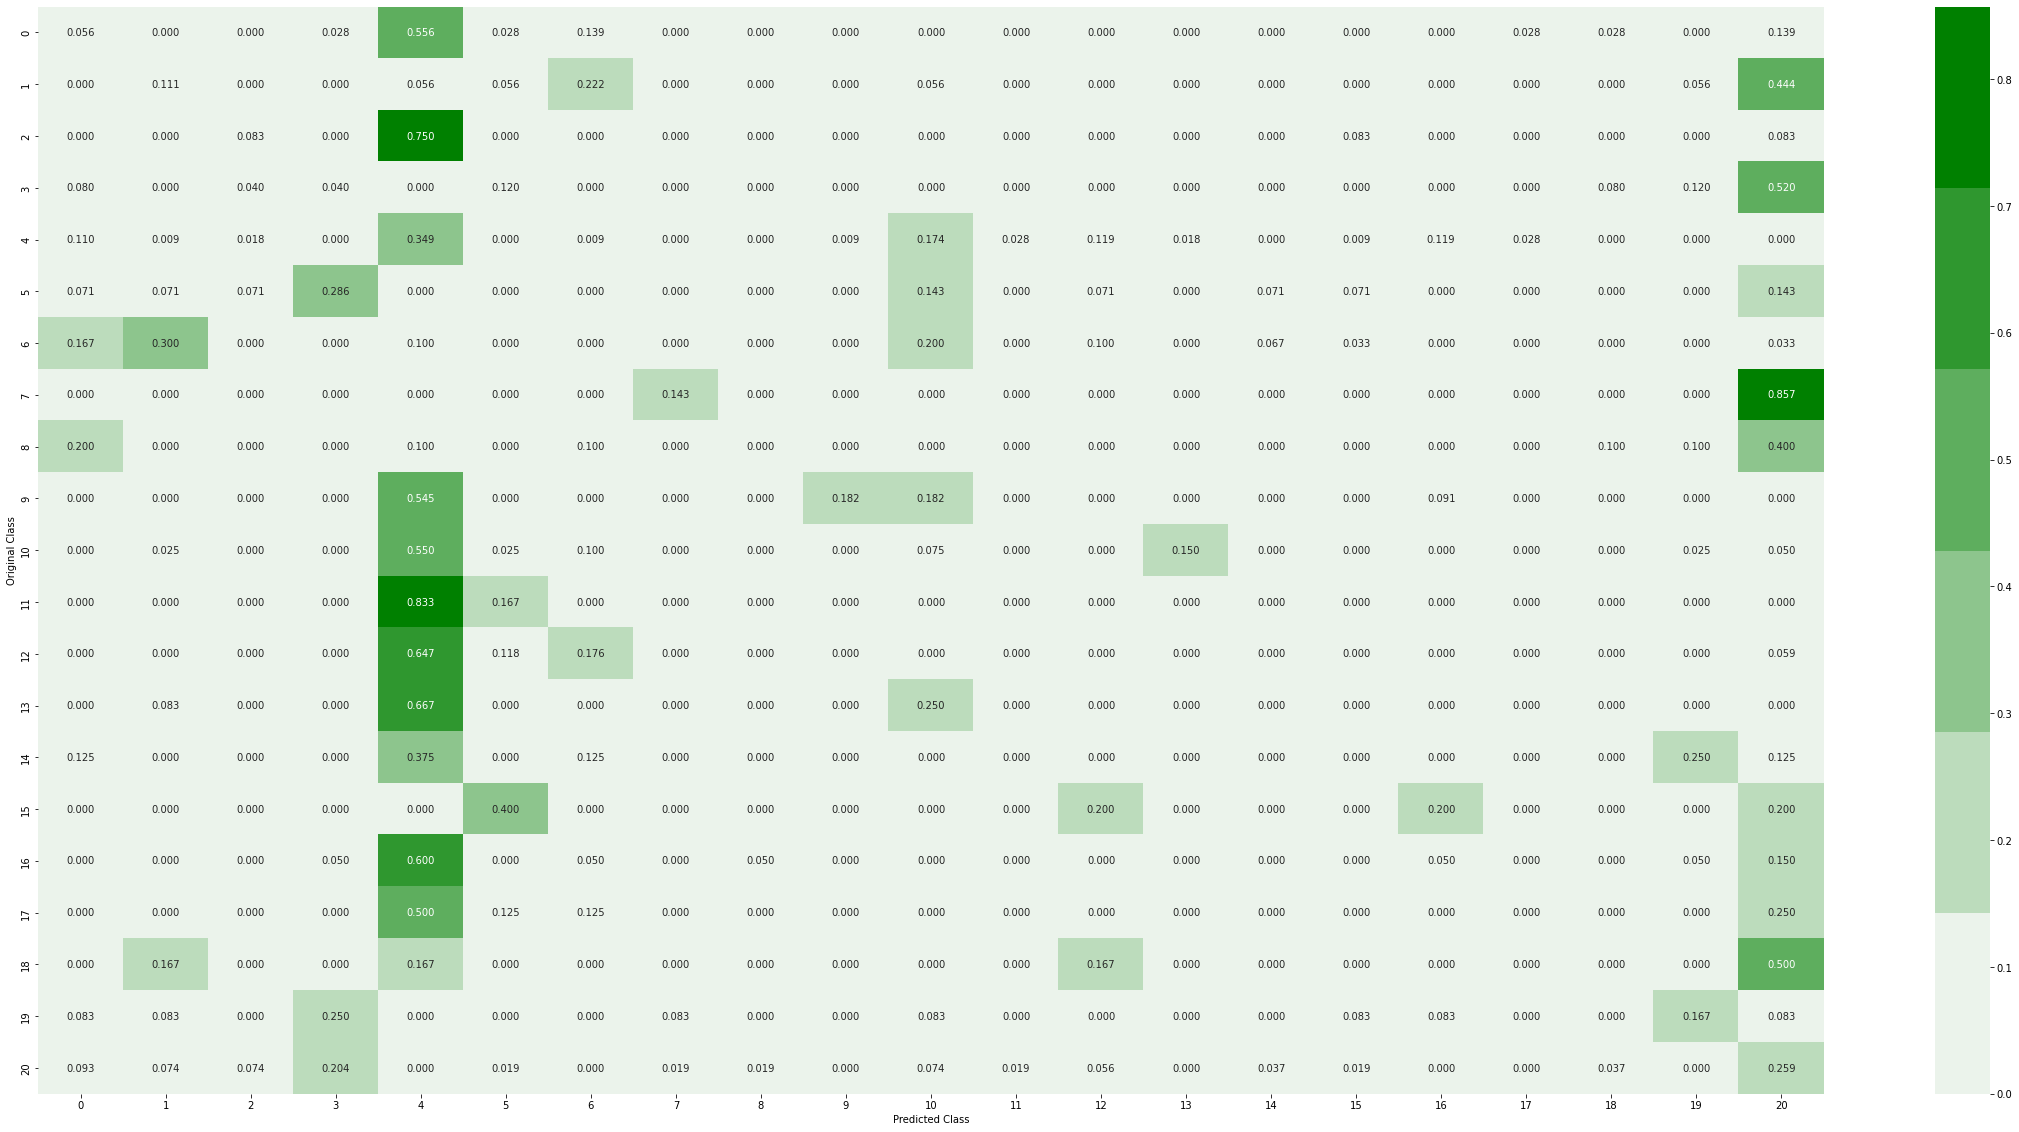

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
predict_y = sclf.predict_proba(x_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sclf.predict_proba(x_val)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y))
predict_y = sclf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test,sclf.predict(x_test))

In [ ]:
from prettytable import PrettyTable
p = PrettyTable()

p.field_names = ["ML Model","Train log loss", "CV log loss", "Test log loss","Number of misclassified points"]
p.add_row(["Random Model",3.348,'-',3.411,95.869])
p.add_row(["Stacked (XGBClassifier,SGDClassifier,RandomForestClassifier",0.833,4.397,4.5100,85.434])


p.add_row(["RandomForestClassifier",2.129,2.648,2.665,76.956])

p.add_row(["Stacked (AdaBoostClassifier,SGDClassifier,RandomForestClassifier",0.941,2.547,2.474,73.478])

p.add_row(["LogisticRegression",1.915,2.022,2.089,74.347])
print(p)


+------------------------------------------------------------------+----------------+-------------+---------------+--------------------------------+
|                             ML Model                             | Train log loss | CV log loss | Test log loss | Number of misclassified points |
+------------------------------------------------------------------+----------------+-------------+---------------+--------------------------------+
|                           Random Model                           |     3.348      |      -      |     3.411     |             95.869             |
|   Stacked (XGBClassifier,SGDClassifier,RandomForestClassifier    |     0.833      |    4.397    |      4.51     |             85.434             |
|                      RandomForestClassifier                      |     2.129      |    2.648    |     2.665     |             76.956             |
| Stacked (AdaBoostClassifier,SGDClassifier,RandomForestClassifier |     0.941      |    2.547    |     2.

# DEEP LEARNING MODEL

BERT MODEL

In [ ]:
df

,Unnamed: 0,ID,transcription,medical_specialty,transcription_Tokenizer,text_string,text_string_freq_dist,text_Lemmatizer,Tweet_w2v,0,...,290,291,292,293,294,295,296,297,298,299
0,0,0,d mmode left atrial enlargement with left a...,0,"['mmode', 'left', 'atrial', 'enlargement', 'le...",mmode left atrial enlargement left atrial diam...,mmode left atrial enlargement left atrial diam...,mmode left atrial enlargement left atrial diam...,[ -63.42107485 226.13847446 -68.93096065 23...,-63.421075,...,84.865350,129.542602,241.406829,-140.245354,-135.183559,-35.538080,104.368609,-357.795179,-331.327617,67.177384
1,1,1,the left ventricular cavity size and wall th...,0,"['left', 'ventricular', 'cavity', 'size', 'wal...",left ventricular cavity size wall thickness ap...,left ventricular cavity size wall thickness ap...,left ventricular cavity size wall thickness ap...,[ -385.86802739 572.2606627 -695.58692868 ...,-385.868027,...,394.563330,174.920979,947.895477,-523.587767,-455.392948,228.881534,520.438032,-982.432869,-1181.492451,288.990995
2,2,2,d echocardiogrammultiple views of the heart an...,0,"['echocardiogrammultiple', 'views', 'heart', '...",echocardiogrammultiple views heart great vesse...,echocardiogrammultiple views heart great vesse...,echocardiogrammultiple views heart great vesse...,[-176.00636812 131.22970943 -359.477253 8...,-176.006368,...,279.779955,156.083638,441.975554,-246.189353,-50.876354,-29.052288,289.609046,-512.560186,-591.618255,148.638033
3,3,3,description normal cardiac chambers size nor...,0,"['description', 'normal', 'cardiac', 'chambers...",description normal cardiac chambers size norma...,description normal cardiac chambers size norma...,description normal cardiac chambers size norma...,[ -81.84593607 131.04025245 -175.64666894 24...,-81.845936,...,47.544825,130.545250,305.960139,-93.438380,-211.205091,0.876420,76.057056,-314.636144,-352.669352,108.390366
4,4,4,d study mild aortic stenosis widely calcified ...,0,"['study', 'mild', 'aortic', 'stenosis', 'widel...",study mild aortic stenosis widely calcified mi...,study mild aortic stenosis widely calcified mi...,study mild aortic stenosis widely calcified mi...,[-8.28803450e+00 1.89161083e+02 -1.79113956e+...,-8.288034,...,120.179318,-137.912541,330.728636,-171.595683,-110.024514,99.573125,248.774286,-372.621075,-446.235002,249.241068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4592,4592,4592,indication chest paintype of test adenosine ...,0,"['indication', 'chest', 'paintype', 'test', 'a...",indication chest paintype test adenosine nucle...,indication chest paintype test adenosine nucle...,indication chest paintype test adenosine nucle...,[ -117.96897796 185.64307952 -168.64511941 ...,-117.968978,...,260.023650,-67.553452,660.670550,-349.651259,-250.385825,217.645975,307.430076,-481.417653,-477.952269,291.293935
4593,4593,4593,chief complaint chest painhistory of present ...,0,"['chief', 'complaint', 'chest', 'painhistory',...",chief complaint chest painhistory present illn...,chief complaint chest painhistory present illn...,chief complaint chest painhistory present illn...,[ -33.85639815 158.31705574 -693.28959455 ...,-33.856398,...,820.516811,-219.572884,495.476164,-595.607963,-824.288573,232.593088,923.912422,-743.760932,-855.856521,777.865354
4594,4594,4594,history of present illness the patient is a y...,0,"['history', 'present', 'illness', 'patient', '...",history present illness patient yearold woman ...,history present illness patient yearold woman ...,history present illness patient yearold woman ...,[ 2.52053357e+01 9.54177412e+02 -2.13265355e+...,25.205336,...,1584.283747,-1084.319904,1826.027759,-1646.297534,-2666.753141,461.999096,1656.463743,-2560.380648,-2625.987417,1801.691802
4595,4595,4595,history of present illness mr abc is a yearol...,0,"['history', 'present', 'illness', 'mr', 'abc',...",history present illness abc yearold gentleman ...,history present illness abc yearold gentleman ...,history

In [ ]:
lens=[]
for each in df.text_Lemmatizer.values:
  lens.append(len(each.split()))

In [ ]:
print('max length of sentence:',max(lens))

max length of sentence: 1247


In [ ]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 512

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

In [ ]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_mask[0][0]',         

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('tokenization.py','wb').write(src)

Saving tokenization.py to tokenization.py


17318

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 13.1 MB/s 


In [ ]:
import tokenization

In [ ]:
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )

In [ ]:
df

,Unnamed: 0,ID,transcription,medical_specialty,transcription_Tokenizer,text_string,text_string_freq_dist,text_Lemmatizer,Tweet_w2v,0,...,290,291,292,293,294,295,296,297,298,299
0,0,0,d mmode left atrial enlargement with left a...,0,"['mmode', 'left', 'atrial', 'enlargement', 'le...",mmode left atrial enlargement left atrial diam...,mmode left atrial enlargement left atrial diam...,mmode left atrial enlargement left atrial diam...,[ -63.42107485 226.13847446 -68.93096065 23...,-63.421075,...,84.865350,129.542602,241.406829,-140.245354,-135.183559,-35.538080,104.368609,-357.795179,-331.327617,67.177384
1,1,1,the left ventricular cavity size and wall th...,0,"['left', 'ventricular', 'cavity', 'size', 'wal...",left ventricular cavity size wall thickness ap...,left ventricular cavity size wall thickness ap...,left ventricular cavity size wall thickness ap...,[ -385.86802739 572.2606627 -695.58692868 ...,-385.868027,...,394.563330,174.920979,947.895477,-523.587767,-455.392948,228.881534,520.438032,-982.432869,-1181.492451,288.990995
2,2,2,d echocardiogrammultiple views of the heart an...,0,"['echocardiogrammultiple', 'views', 'heart', '...",echocardiogrammultiple views heart great vesse...,echocardiogrammultiple views heart great vesse...,echocardiogrammultiple views heart great vesse...,[-176.00636812 131.22970943 -359.477253 8...,-176.006368,...,279.779955,156.083638,441.975554,-246.189353,-50.876354,-29.052288,289.609046,-512.560186,-591.618255,148.638033
3,3,3,description normal cardiac chambers size nor...,0,"['description', 'normal', 'cardiac', 'chambers...",description normal cardiac chambers size norma...,description normal cardiac chambers size norma...,description normal cardiac chambers size norma...,[ -81.84593607 131.04025245 -175.64666894 24...,-81.845936,...,47.544825,130.545250,305.960139,-93.438380,-211.205091,0.876420,76.057056,-314.636144,-352.669352,108.390366
4,4,4,d study mild aortic stenosis widely calcified ...,0,"['study', 'mild', 'aortic', 'stenosis', 'widel...",study mild aortic stenosis widely calcified mi...,study mild aortic stenosis widely calcified mi...,study mild aortic stenosis widely calcified mi...,[-8.28803450e+00 1.89161083e+02 -1.79113956e+...,-8.288034,...,120.179318,-137.912541,330.728636,-171.595683,-110.024514,99.573125,248.774286,-372.621075,-446.235002,249.241068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4592,4592,4592,indication chest paintype of test adenosine ...,0,"['indication', 'chest', 'paintype', 'test', 'a...",indication chest paintype test adenosine nucle...,indication chest paintype test adenosine nucle...,indication chest paintype test adenosine nucle...,[ -117.96897796 185.64307952 -168.64511941 ...,-117.968978,...,260.023650,-67.553452,660.670550,-349.651259,-250.385825,217.645975,307.430076,-481.417653,-477.952269,291.293935
4593,4593,4593,chief complaint chest painhistory of present ...,0,"['chief', 'complaint', 'chest', 'painhistory',...",chief complaint chest painhistory present illn...,chief complaint chest painhistory present illn...,chief complaint chest painhistory present illn...,[ -33.85639815 158.31705574 -693.28959455 ...,-33.856398,...,820.516811,-219.572884,495.476164,-595.607963,-824.288573,232.593088,923.912422,-743.760932,-855.856521,777.865354
4594,4594,4594,history of present illness the patient is a y...,0,"['history', 'present', 'illness', 'patient', '...",history present illness patient yearold woman ...,history present illness patient yearold woman ...,history present illness patient yearold woman ...,[ 2.52053357e+01 9.54177412e+02 -2.13265355e+...,25.205336,...,1584.283747,-1084.319904,1826.027759,-1646.297534,-2666.753141,461.999096,1656.463743,-2560.380648,-2625.987417,1801.691802
4595,4595,4595,history of present illness mr abc is a yearol...,0,"['history', 'present', 'illness', 'mr', 'abc',...",history present illness abc yearold gentleman ...,history present illness abc yearold gentleman ...,history

In [ ]:
X = df.text_Lemmatizer

In [ ]:
#Y = pd.factorize(df['medical_specialty'])[0].reshape(-1, 1) 

In [ ]:
Y = (df['medical_specialty'])

In [ ]:
Y

0       0
1       0
2       0
3       0
4       0
       ..
4592    0
4593    0
4594    0
4595    0
4596    0
Name: medical_specialty, Length: 4597, dtype: int64

In [ ]:
Y.value_counts().sum()

4597

In [ ]:
Y.shape

(4597,)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.33, random_state=0,stratify=Y)
X_train.shape, X_test.shape , Y_train.shape , Y_test.shape

((3079,), (1518,), (3079,), (1518,))

In [ ]:
X_train

3567    chief complaint foot painhistory present illne...
2311    preoperative diagnosis bilateral upper eyelid ...
643     preoperative diagnosis dural tear postoperativ...
1528    difficulty speechhx rhm awoke early prepare pl...
3440    assessment peripheral vestibular function foll...
                              ...                        
302     preoperative diagnosis right carpal tunnel syn...
872     preoperative diagnosis traumatic injury bilate...
3077    subjective patient wellknown comes today compr...
2179    title operation arthrotomy removal humeral hea...
1837    preoperative diagnosis low back painpostoperat...
Name: text_Lemmatizer, Length: 3079, dtype: object

In [ ]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(np.asarray(Y_train))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (3079, 21)


In [ ]:
from keras.utils.np_utils import to_categorical
y_test = to_categorical(np.asarray(Y_test))
print('Shape of label tensor:', y_test.shape)

Shape of label tensor: (1518, 21)


In [ ]:
max_tokens = 512
X_train_tokens=[]
X_train_mask = []
X_train_segment = []
# iterate over X_train
for i in tqdm_notebook(range(len(X_train))):
    token=tokenizer.tokenize(X_train.values[i][0])
    if len(token)>= max_tokens-2:
        token = token[0:(max_tokens-2)]
    # adding [CLS] at start and [SEP] at end
    token = ['[CLS]',*token,'[SEP]']
    pad = max_tokens - len(token)
    if pad > 0 :
        #adding Padding
        padding = ['[PAD]']*pad
        temp_tokens_fix = [*token,*padding]
    else:
        temp_tokens_fix = token
    tokens      = np.array(tokenizer.convert_tokens_to_ids(temp_tokens_fix))
    mask_tokens = np.array([1]*len(token)+[0]*pad)
    seg_tokens  = np.array([0]*len(temp_tokens_fix))
    
    X_train_tokens.append(tokens)
    X_train_mask.append(mask_tokens)
    X_train_segment.append(seg_tokens)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/3079 [00:00<?, ?it/s]

In [ ]:
#Convert all into np.array
X_train_tokens = np.array(X_train_tokens)
X_train_mask = np.array(X_train_mask)
X_train_segment = np.array(X_train_segment)

In [ ]:
# Processing to get X_test_tokens, X_test_mask, X_test_segment
max_tokens = 512
X_test_tokens=[]
X_test_mask = []
X_test_segment = []
# Iterate over X_test 
for i in tqdm_notebook(range(len(X_test))):
    # Tokenixe each review
    token=tokenizer.tokenize(X_test.values[i][0])
    # Truncating if review is large 
    if len(token)>= max_tokens-2:
        token = token[0:(max_tokens-2)]
    # adding [CLS] at start and [SEP] at end
    token = ['[CLS]',*token,'[SEP]']
    pad = max_tokens - len(token)
    #adding Padding upto max token size
    if pad > 0 :
        padding = ['[PAD]']*pad
        temp_tokens_fix = [*token,*padding]
    else:
        temp_tokens_fix = token
    # Convert Tokens to ids
    tokens      = np.array(tokenizer.convert_tokens_to_ids(temp_tokens_fix))
    #Creating mask token and segment token of each review
    mask_tokens = np.array([1]*len(token)+[0]*pad)
    seg_tokens  = np.array([0]*len(temp_tokens_fix))
    # Appending the review converted to id, the mask and segment tokens
    X_test_tokens.append(tokens)
    X_test_mask.append(mask_tokens)
    X_test_segment.append(seg_tokens)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/1518 [00:00<?, ?it/s]

In [ ]:
#Convert all into np.array
X_test_tokens = np.array(X_test_tokens)
X_test_mask = np.array(X_test_mask)
X_test_segment = np.array(X_test_segment)

In [ ]:
import pickle
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, Y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, Y_test),open('test_data.pkl','wb'))

In [ ]:
bert_model.input

[<KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'segment_ids')>]

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [ ]:
X_train_tokens.shape

(3079, 512)

In [ ]:
X_train_mask.shape

(3079, 512)

In [ ]:
X_train_segment.shape

(3079, 512)

In [ ]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output

X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [ ]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [ ]:
y_train.shape

(3079, 21)

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [ ]:
class Metrics(Callback):
  def on_train_begin(self, logs={}):
    self.metrics_ = {'auc_score': []} # creating a dictionary to store auc score values
 
  def on_epoch_end(self, epoch, logs={}):
    val_predict_prob = self.model.predict(X_test_pooled_output) # predicting the probability values of test data
    # to calculate auc scores, we need probability values predicted
    self.metrics_['auc_score'].append(roc_auc_score(y_test,val_predict_prob))# storing auc scores

    print(' auc_score: ',self.metrics_['auc_score'][epoch]) # printing f1 score and auc score after each epoch

auc_metrics = Metrics() # assigning a variable to the Metrics class

In [ ]:
def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy('balanced_accuracy'),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

In [ ]:
Y_test.shape

(1518,)

In [ ]:
#Selecting Best Hyperparameters for the neural netwoek
def best_hyperparameters(activ_mult,learn_rate_mult):

    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()
    input_layer=Input(shape=(X_train_pooled_output.shape[1],))
   

    input_layer = Input(shape=(X_train_pooled_output.shape[1],))
    dense_layer_1 = Dense(128, activation='relu')(input_layer)
    dropout_layer_1 = tf.keras.layers.Dropout(0.1)(dense_layer_1)
    dense_layer_2 = Dense(32,activation = 'relu')(dropout_layer_1)
    #output layer
    output = Dense(21,activation='softmax',name = "output")(dense_layer_2)

    #Creating a model
    model = Model(inputs=input_layer,outputs=output)
    #compiling 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate_mult),loss='CategoricalCrossentropy',metrics=['AUC','accuracy'])

    return model

In [ ]:
# Grid Search over the following parameters
activ_mult = ['relu','LeakyRelu']
learn_rate_mult = [10 ** x for x in range(-5, 4)]

In [ ]:
# All parameters added to a dictionary
param_grid = dict(activ_mult=activ_mult,learn_rate_mult=learn_rate_mult)

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV



# Creating model for Classfication for grid search 
model = KerasClassifier(build_fn=best_hyperparameters, epochs=5, batch_size=10, verbose=0)
param_grid = dict(activ_mult=activ_mult,learn_rate_mult=learn_rate_mult)
#Get NN model with best hyperparameters using Grid Search 
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train_pooled_output, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  import sys


In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.329325 using {'activ_mult': 'relu', 'learn_rate_mult': 0.001}


In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()
input_layer=Input(shape=(X_train_pooled_output.shape[1],))
   

input_layer = Input(shape=(X_train_pooled_output.shape[1],))
dense_layer_1 = Dense(128, activation='relu')(input_layer)
dropout_layer_1 = tf.keras.layers.Dropout(0.1)(dense_layer_1)

dense_layer_2 = Dense(128, activation='relu')(dropout_layer_1)
dropout_layer_2 = tf.keras.layers.Dropout(0.1)(dense_layer_2)
dense_layer_3 = Dense(32,activation = 'relu')(dropout_layer_2)
#output layer
output = Dense(21,activation='softmax',name = "output")(dense_layer_3)

#Creating a model
model_ = Model(inputs=input_layer,outputs=output)

In [ ]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy('balanced_accuracy'),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]


earlystop_callback =  tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience=2, verbose=1)

def LearningRatesc(epoch,lr):
  if (epoch+1)%3 ==0:
    lr = 0.95*lr
  return lr


filepath="/content/drive/MyDrive/weights_copy_new_23_1.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_balanced_accuracy', verbose=1, save_best_only=True, mode='max')
 

lrschedule = LearningRateScheduler(LearningRatesc)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                             patience=5, min_lr=0.001)

nan_termination = TerminateOnNaN()

In [ ]:
log_dir="/content/drive/MyDrive/logs/{}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

optimizers = tf.keras.optimizers.Adam(learning_rate=0.001)
#compiling 
model_.compile(optimizer=optimizers,loss='CategoricalCrossentropy',metrics=[METRICS])
custom_callbacks = [earlystop_callback,lrschedule, reduce_lr,nan_termination,tensorboard_callback,checkpoint]

In [ ]:
model_.fit(X_train_pooled_output, y_train, epochs=40, validation_data=(X_test_pooled_output,y_test), batch_size=10,callbacks=[custom_callbacks],verbose=1)

Epoch 1/40
306/308 [============================>.] - ETA: 0s - loss: 2.6085 - balanced_accuracy: 0.2735 - balanced_recall: 0.0071 - balanced_precision: 0.0080 - balanced_f1_score: 0.0065
Epoch 1: val_balanced_accuracy improved from -inf to 0.30896, saving model to /content/drive/MyDrive/weights_copy_new_23_1.best.hdf5
308/308 [==============================] - 9s 13ms/step - loss: 2.6075 - balanced_accuracy: 0.2735 - balanced_recall: 0.0071 - balanced_precision: 0.0080 - balanced_f1_score: 0.0065 - val_loss: 2.4848 - val_balanced_accuracy: 0.3090 - val_balanced_recall: 0.0000e+00 - val_balanced_precision: 0.0000e+00 - val_balanced_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/40
307/308 [============================>.] - ETA: 0s - loss: 2.4730 - balanced_accuracy: 0.3020 - balanced_recall: 0.0116 - balanced_precision: 0.0127 - balanced_f1_score: 0.0111
Epoch 2: val_balanced_accuracy improved from 0.30896 to 0.30962, saving model to /content/drive/MyDrive/weights_copy_new_23_1.best.hdf5
30

In [ ]:
# libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
np.random.seed(32)


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.utils.np_utils import to_categorical

import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier


%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/case study 2/preprocess_data.csv')

In [ ]:
df

,Unnamed: 0,ID,transcription,medical_specialty,transcription_Tokenizer,text_string,text_string_freq_dist,text_Lemmatizer,Tweet_w2v,0,...,290,291,292,293,294,295,296,297,298,299
0,0,0,d mmode left atrial enlargement with left a...,0,"['mmode', 'left', 'atrial', 'enlargement', 'le...",mmode left atrial enlargement left atrial diam...,mmode left atrial enlargement left atrial diam...,mmode left atrial enlargement left atrial diam...,[ -63.42107485 226.13847446 -68.93096065 23...,-63.421075,...,84.865350,129.542602,241.406829,-140.245354,-135.183559,-35.538080,104.368609,-357.795179,-331.327617,67.177384
1,1,1,the left ventricular cavity size and wall th...,0,"['left', 'ventricular', 'cavity', 'size', 'wal...",left ventricular cavity size wall thickness ap...,left ventricular cavity size wall thickness ap...,left ventricular cavity size wall thickness ap...,[ -385.86802739 572.2606627 -695.58692868 ...,-385.868027,...,394.563330,174.920979,947.895477,-523.587767,-455.392948,228.881534,520.438032,-982.432869,-1181.492451,288.990995
2,2,2,d echocardiogrammultiple views of the heart an...,0,"['echocardiogrammultiple', 'views', 'heart', '...",echocardiogrammultiple views heart great vesse...,echocardiogrammultiple views heart great vesse...,echocardiogrammultiple views heart great vesse...,[-176.00636812 131.22970943 -359.477253 8...,-176.006368,...,279.779955,156.083638,441.975554,-246.189353,-50.876354,-29.052288,289.609046,-512.560186,-591.618255,148.638033
3,3,3,description normal cardiac chambers size nor...,0,"['description', 'normal', 'cardiac', 'chambers...",description normal cardiac chambers size norma...,description normal cardiac chambers size norma...,description normal cardiac chambers size norma...,[ -81.84593607 131.04025245 -175.64666894 24...,-81.845936,...,47.544825,130.545250,305.960139,-93.438380,-211.205091,0.876420,76.057056,-314.636144,-352.669352,108.390366
4,4,4,d study mild aortic stenosis widely calcified ...,0,"['study', 'mild', 'aortic', 'stenosis', 'widel...",study mild aortic stenosis widely calcified mi...,study mild aortic stenosis widely calcified mi...,study mild aortic stenosis widely calcified mi...,[-8.28803450e+00 1.89161083e+02 -1.79113956e+...,-8.288034,...,120.179318,-137.912541,330.728636,-171.595683,-110.024514,99.573125,248.774286,-372.621075,-446.235002,249.241068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4592,4592,4592,indication chest paintype of test adenosine ...,0,"['indication', 'chest', 'paintype', 'test', 'a...",indication chest paintype test adenosine nucle...,indication chest paintype test adenosine nucle...,indication chest paintype test adenosine nucle...,[ -117.96897796 185.64307952 -168.64511941 ...,-117.968978,...,260.023650,-67.553452,660.670550,-349.651259,-250.385825,217.645975,307.430076,-481.417653,-477.952269,291.293935
4593,4593,4593,chief complaint chest painhistory of present ...,0,"['chief', 'complaint', 'chest', 'painhistory',...",chief complaint chest painhistory present illn...,chief complaint chest painhistory present illn...,chief complaint chest painhistory present illn...,[ -33.85639815 158.31705574 -693.28959455 ...,-33.856398,...,820.516811,-219.572884,495.476164,-595.607963,-824.288573,232.593088,923.912422,-743.760932,-855.856521,777.865354
4594,4594,4594,history of present illness the patient is a y...,0,"['history', 'present', 'illness', 'patient', '...",history present illness patient yearold woman ...,history present illness patient yearold woman ...,history present illness patient yearold woman ...,[ 2.52053357e+01 9.54177412e+02 -2.13265355e+...,25.205336,...,1584.283747,-1084.319904,1826.027759,-1646.297534,-2666.753141,461.999096,1656.463743,-2560.380648,-2625.987417,1801.691802
4595,4595,4595,history of present illness mr abc is a yearol...,0,"['history', 'present', 'illness', 'mr', 'abc',...",history present illness abc yearold gentleman ...,history present illness abc yearold gentleman ...,history

In [ ]:
X = df.text_Lemmatizer

In [ ]:
Y = (df['medical_specialty'])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.33, random_state=0,stratify=Y)

In [ ]:
X_train

3567    chief complaint foot painhistory present illne...
2311    preoperative diagnosis bilateral upper eyelid ...
643     preoperative diagnosis dural tear postoperativ...
1528    difficulty speechhx rhm awoke early prepare pl...
3440    assessment peripheral vestibular function foll...
                              ...                        
302     preoperative diagnosis right carpal tunnel syn...
872     preoperative diagnosis traumatic injury bilate...
3077    subjective patient wellknown comes today compr...
2179    title operation arthrotomy removal humeral hea...
1837    preoperative diagnosis low back painpostoperat...
Name: text_Lemmatizer, Length: 3079, dtype: object

In [ ]:
X_train.shape

(3079,)

In [ ]:

y_train = to_categorical(np.asarray(Y_train))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (3079, 21)


In [ ]:
y_test = to_categorical(np.asarray(Y_train))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (3079, 21)


# SEQUENCE TO SEQUENCE

In [ ]:
MAX_NB_WORDS = 1247

# get the raw text data
texts_train = X_train.astype(str)
texts_test = X_test.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 33034 unique tokens.


In [ ]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 33034)

In [ ]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [ ]:
" ".join([index_to_word[i] for i in sequences[0]])

'chief complaint foot present illness yearold high school weight dorsal feet time hour prior injury feet brought care able weight however pain toes patient skin across second third toes left foot across second third toes foot patient state health prior acute medical history significant attention surgical history positive history history use alcohol tobacco school history systems review systems noted remaining review systems reviewed noted medications examinationgeneral pleasant white male acute signs stable within normal negative acute evidence trauma injury regular rate rhythm across right foot including second third toes mild tenderness palpation however clinical distal pulses intact left foot notes superficial third range motion decreased secondary pain obvious exam exam alert awake appropriate without lateral oblique views feet per negative acute significant soft tissue swelling bony patient informed xray findings patient discharged care mother diagnosis bilateral foot superficial 

In [ ]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 166.8
max length: 806


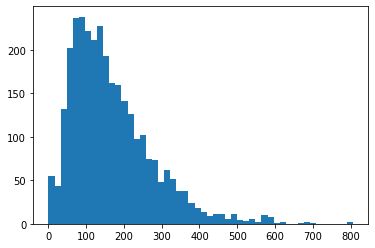

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

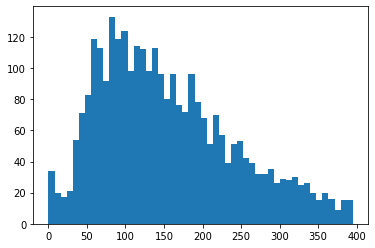

In [ ]:
plt.hist([l for l in seq_lens if l < 400], bins=50);

In [ ]:
MAX_SEQUENCE_LENGTH = 375

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (3079, 375)
Shape of data test tensor: (1518, 375)


In [ ]:
x_train

array([[   0,    0,    0, ...,  791,  356,   16],
       [   0,    0,    0, ...,  156,  368,   96],
       [   0,    0,    0, ...,   67,   96,  232],
       ...,
       [   0,    0,    0, ...,  157,  822, 1154],
       [ 188,  755,   79, ...,  155,   73,  551],
       [   0,    0,    0, ...,    1, 1093,  228]], dtype=int32)

In [ ]:
def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy('balanced_accuracy'),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]


earlystop_callback =  tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience=2, verbose=1)

def LearningRatesc(epoch,lr):
  if (epoch+1)%3 ==0:
    lr = 0.95*lr
  return lr


filepath="/content/drive/MyDrive/weights_copy_new_23_1.best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_balanced_accuracy', verbose=1, save_best_only=True, mode='max')
 

lrschedule = LearningRateScheduler(LearningRatesc)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                             patience=5, min_lr=0.001)

nan_termination = TerminateOnNaN()

In [ ]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model
MAX_SEQUENCE_LENGTH = 375

EMBEDDING_DIM = 170
N_CLASSES = 21

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [ ]:
log_dir="/content/drive/MyDrive/logs/{}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

#optimizers = tf.keras.optimizers.Adam(
    #learning_rate=5e-05,
    #decay = 1e-4,
    #name="Adam"
    #5e-05
    #epsilon=1e-08,
     #decay=0.01,
    #clipnorm=1.0,)
#compiling 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='CategoricalCrossentropy',metrics=[METRICS])
custom_callbacks = [earlystop_callback,lrschedule, reduce_lr,nan_termination,tensorboard_callback,checkpoint]

In [ ]:
model.fit(x_train, y_train, epochs=40, validation_split=0.1, batch_size=10,callbacks=[custom_callbacks],verbose=1)

Epoch 1/40
278/278 [==============================] - ETA: 0s - loss: 1.5513 - balanced_accuracy: 0.4522 - balanced_recall: 0.0468 - balanced_precision: 0.0546 - balanced_f1_score: 0.0488
Epoch 1: val_balanced_accuracy did not improve from 0.38312
278/278 [==============================] - 3s 9ms/step - loss: 1.5513 - balanced_accuracy: 0.4522 - balanced_recall: 0.0468 - balanced_precision: 0.0546 - balanced_f1_score: 0.0488 - val_loss: 1.8206 - val_balanced_accuracy: 0.3734 - val_balanced_recall: 0.0321 - val_balanced_precision: 0.0388 - val_balanced_f1_score: 0.0330 - lr: 5.1334e-04
Epoch 2/40
278/278 [==============================] - ETA: 0s - loss: 1.5053 - balanced_accuracy: 0.4590 - balanced_recall: 0.0498 - balanced_precision: 0.0581 - balanced_f1_score: 0.0521
Epoch 2: val_balanced_accuracy did not improve from 0.38312
278/278 [==============================] - 2s 9ms/step - loss: 1.5053 - balanced_accuracy: 0.4590 - balanced_recall: 0.0498 - balanced_precision: 0.0581 - balan

# LSTM

In [ ]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)
predictions = Dense(21, activation='softmax')(x)


model_1 = Model(sequence_input, predictions)
model_1.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=[METRICS])

In [ ]:
model_1.fit(x_train, y_train, epochs=40, validation_split=0.1, batch_size=10,callbacks=[custom_callbacks],verbose=1)

Epoch 1/40
278/278 [==============================] - ETA: 0s - loss: 1.9856 - balanced_accuracy: 0.3722 - balanced_recall: 0.0250 - balanced_precision: 0.0278 - balanced_f1_score: 0.0248
Epoch 1: val_balanced_accuracy did not improve from 0.38312
278/278 [==============================] - 438s 2s/step - loss: 1.9856 - balanced_accuracy: 0.3722 - balanced_recall: 0.0250 - balanced_precision: 0.0278 - balanced_f1_score: 0.0248 - val_loss: 1.9394 - val_balanced_accuracy: 0.3636 - val_balanced_recall: 0.0385 - val_balanced_precision: 0.0443 - val_balanced_f1_score: 0.0394 - lr: 0.0010
Epoch 2/40
278/278 [==============================] - ETA: 0s - loss: 1.6112 - balanced_accuracy: 0.4424 - balanced_recall: 0.0524 - balanced_precision: 0.0574 - balanced_f1_score: 0.0529
Epoch 2: val_balanced_accuracy did not improve from 0.38312
278/278 [==============================] - 421s 2s/step - loss: 1.6112 - balanced_accuracy: 0.4424 - balanced_recall: 0.0524 - balanced_precision: 0.0574 - balance

# LSTM WITH COMPLEX MODEL

In [ ]:
MAX_SEQUENCE_LENGTH

375

In [ ]:
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 21 output channels
x = Conv1D(64, 5)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 5)(x)
x = MaxPooling1D(5)(x)
# LSTM layer with a hidden size of 64
x = Dropout(0.2)(x)
x = LSTM(64)(x)
predictions = Dense(21, activation='softmax')(x)

model_2 = Model(sequence_input, predictions)
model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[METRICS])

In [ ]:
model_2.fit(x_train, y_train, epochs=40, validation_split=0.3, batch_size=10,callbacks=[custom_callbacks],verbose=1)

Epoch 1/40
215/216 [============================>.] - ETA: 0s - loss: 2.1547 - balanced_accuracy: 0.3536 - balanced_recall: 0.0243 - balanced_precision: 0.0254 - balanced_f1_score: 0.0237
Epoch 1: val_balanced_accuracy did not improve from 0.37013
216/216 [==============================] - 27s 103ms/step - loss: 2.1548 - balanced_accuracy: 0.3537 - balanced_recall: 0.0246 - balanced_precision: 0.0258 - balanced_f1_score: 0.0240 - val_loss: 1.9727 - val_balanced_accuracy: 0.3593 - val_balanced_recall: 0.0348 - val_balanced_precision: 0.0377 - val_balanced_f1_score: 0.0347 - lr: 0.0010
Epoch 2/40
215/216 [============================>.] - ETA: 0s - loss: 1.5840 - balanced_accuracy: 0.4530 - balanced_recall: 0.0563 - balanced_precision: 0.0632 - balanced_f1_score: 0.0578
Epoch 2: val_balanced_accuracy did not improve from 0.37013
216/216 [==============================] - 16s 76ms/step - loss: 1.5847 - balanced_accuracy: 0.4524 - balanced_recall: 0.0561 - balanced_precision: 0.0629 - bala

# Use scikit-learn to grid search the batch size and epochs

In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

# Function to create model, required for KerasClassifier
def create_model():
	# create model
	model = Sequential()
	model.add(Dense(12, input_shape=(375,), activation='relu'))
	model.add(Dense(21, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[METRICS])
	return model
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

# create model
model = KerasClassifier(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.236115 using {'batch_size': 10, 'epochs': 50}
0.235140 (0.004338) with: {'batch_size': 10, 'epochs': 10}
0.236115 (0.004788) with: {'batch_size': 10, 'epochs': 50}
0.235792 (0.005765) with: {'batch_size': 10, 'epochs': 100}
0.235140 (0.006597) with: {'batch_size': 20, 'epochs': 10}
0.234492 (0.003583) with: {'batch_size': 20, 'epochs': 50}
0.234816 (0.005205) with: {'batch_size': 20, 'epochs': 100}
0.233842 (0.006789) with: {'batch_size': 40, 'epochs': 10}
0.233517 (0.004627) with: {'batch_size': 40, 'epochs': 50}
0.235790 (0.004177) with: {'batch_size': 40, 'epochs': 100}
0.233841 (0.004082) with: {'batch_size': 60, 'epochs': 10}
0.234816 (0.005997) with: {'batch_size': 60, 'epochs': 50}
0.235466 (0.004061) with: {'batch_size': 60, 'epochs': 100}
0.232542 (0.004627) with: {'batch_size': 80, 'epochs': 10}
0.234491 (0.005985) with: {'batch_size': 80, 'epochs': 50}
0.234492 (0.006392) with: {'batch_size': 80, 'epochs': 100}
0.231243 (0.005079) with: {'batch_size': 100, 'epochs': 

# Use scikit-learn to grid search optimizer

In [ ]:

# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_shape=(375,), activation='relu'))
	model.add(Dense(21, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[METRICS])
	return model
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

# create model
model = KerasClassifier(model=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(model__optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.237415 using {'model__optimizer': 'RMSprop'}
0.236765 (0.005205) with: {'model__optimizer': 'SGD'}
0.237415 (0.004379) with: {'model__optimizer': 'RMSprop'}
0.229943 (0.004348) with: {'model__optimizer': 'Adagrad'}
0.075676 (0.006409) with: {'model__optimizer': 'Adadelta'}
0.234492 (0.006765) with: {'model__optimizer': 'Adam'}
0.230593 (0.004542) with: {'model__optimizer': 'Adamax'}
0.235140 (0.006597) with: {'model__optimizer': 'Nadam'}


# Use scikit-learn to weight_constraint & dropout_rate

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from scikeras.wrappers import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(dropout_rate, weight_constraint):
	# create model
	model = Sequential()
	model.add(Dense(12, input_shape=(375,), kernel_initializer='uniform', activation='linear', kernel_constraint=MaxNorm(weight_constraint)))
	model.add(Dropout(dropout_rate))
	model.add(Dense(21, kernel_initializer='uniform', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[METRICS])
	return model
# fix random seed for reproducibility

model = KerasClassifier(model=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint=weight_constraint)
#param_grid = dict(model__dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.220526 using {'model__dropout_rate': 0.7, 'model__weight_constraint': 2.0}
0.137062 (0.010288) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 1.0}
0.131864 (0.026279) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 2.0}
0.137384 (0.006962) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 3.0}
0.133809 (0.030243) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 4.0}
0.122769 (0.011799) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 5.0}
0.147127 (0.006925) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 1.0}
0.136076 (0.016950) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 2.0}
0.151680 (0.016605) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 3.0}
0.144206 (0.016588) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 4.0}
0.157516 (0.010070) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 5.0}
0.152965 (0.015896) with: {'model__dr

In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from scikeras.wrappers import KerasClassifier

# use 768 dim data 

In [ ]:
X_train_pooled_output.shape[1]

768

In [ ]:
def create_model(dropout_rate, weight_constraint):
	# create model
	model = Sequential()
	model.add(Dense(12, input_shape=(768,), kernel_initializer='uniform', activation='linear', kernel_constraint=MaxNorm(weight_constraint)))
	model.add(Dropout(dropout_rate))
	model.add(Dense(21, kernel_initializer='uniform', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[METRICS])
	return model

# Use scikit-learn to weight_constraint & dropout_rate

In [ ]:

# Function to create model, required for KerasClassifier

# fix random seed for reproducibility

model = KerasClassifier(model=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint=weight_constraint)
#param_grid = dict(model__dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train_pooled_output,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.365708 using {'model__dropout_rate': 0.2, 'model__weight_constraint': 5.0}
0.325759 (0.008870) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 1.0}
0.353364 (0.005013) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 2.0}
0.358234 (0.008024) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 3.0}
0.361159 (0.006117) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 4.0}
0.365383 (0.010096) with: {'model__dropout_rate': 0.0, 'model__weight_constraint': 5.0}
0.339071 (0.000665) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 1.0}
0.351415 (0.005794) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 2.0}
0.361157 (0.008776) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 3.0}
0.362458 (0.007725) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 4.0}
0.364732 (0.007295) with: {'model__dropout_rate': 0.1, 'model__weight_constraint': 5.0}
0.342321 (0.003912) with: {'model__dr

# Use scikit-learn to grid search optimizer

In [ ]:
def create_model(optimizer='adam'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_shape=(768,), activation='relu'))
	model.add(Dense(21, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[METRICS])
	return model
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

# create model
model = KerasClassifier(model=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(model__optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train_pooled_output,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.354013 using {'model__optimizer': 'Nadam'}
0.323805 (0.003065) with: {'model__optimizer': 'SGD'}
0.307889 (0.034098) with: {'model__optimizer': 'RMSprop'}
0.307559 (0.026975) with: {'model__optimizer': 'Adagrad'}
0.246181 (0.009202) with: {'model__optimizer': 'Adadelta'}
0.345242 (0.002956) with: {'model__optimizer': 'Adam'}
0.341667 (0.008172) with: {'model__optimizer': 'Adamax'}
0.354013 (0.006108) with: {'model__optimizer': 'Nadam'}


# Use scikit-learn to grid search the batch size and epochs

In [ ]:
def create_model():
	# create model
	model = Sequential()
	model.add(Dense(12, input_shape=(768,), activation='relu'))
	model.add(Dense(21, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[METRICS])
	return model
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

# create model
model = KerasClassifier(model=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_pooled_output,y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.345242 using {'batch_size': 10, 'epochs': 50}
0.320233 (0.001513) with: {'batch_size': 10, 'epochs': 10}
0.345242 (0.014756) with: {'batch_size': 10, 'epochs': 50}
0.334852 (0.013431) with: {'batch_size': 10, 'epochs': 100}
0.327056 (0.013941) with: {'batch_size': 20, 'epochs': 10}
0.330305 (0.009766) with: {'batch_size': 20, 'epochs': 50}
0.340693 (0.010177) with: {'batch_size': 20, 'epochs': 100}
0.316010 (0.011996) with: {'batch_size': 40, 'epochs': 10}
0.336797 (0.006412) with: {'batch_size': 40, 'epochs': 50}
0.312139 (0.052719) with: {'batch_size': 40, 'epochs': 100}
0.314063 (0.001080) with: {'batch_size': 60, 'epochs': 10}
0.330953 (0.007216) with: {'batch_size': 60, 'epochs': 50}
0.343617 (0.006716) with: {'batch_size': 60, 'epochs': 100}
0.289062 (0.023723) with: {'batch_size': 80, 'epochs': 10}
0.341019 (0.002718) with: {'batch_size': 80, 'epochs': 50}
0.344269 (0.017145) with: {'batch_size': 80, 'epochs': 100}
0.281574 (0.026274) with: {'batch_size': 100, 'epochs': 

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(activation='relu'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_shape=(768,), kernel_initializer='uniform', activation=activation))
	model.add(Dense(21, kernel_initializer='uniform', activation='sigmoid'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[METRICS])
	return model
# fix random seed for reproducibility

# create model
model = KerasClassifier(model=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_test_pooled_output,y_test)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.357049 using {'model__activation': 'softplus'}
0.313570 (0.009455) with: {'model__activation': 'softmax'}
0.357049 (0.005187) with: {'model__activation': 'softplus'}
0.341238 (0.012111) with: {'model__activation': 'softsign'}
0.344532 (0.003359) with: {'model__activation': 'relu'}
0.338603 (0.009175) with: {'model__activation': 'tanh'}
0.339262 (0.006521) with: {'model__activation': 'sigmoid'}
0.326087 (0.008385) with: {'model__activation': 'hard_sigmoid'}
0.347167 (0.016795) with: {'model__activation': 'linear'}


# Use scikit-learn to grid search the number of neurons

In [ ]:
def create_model(neurons):
	# create model
	model = Sequential()
	model.add(Dense(neurons, input_shape=(768,), kernel_initializer='uniform', activation='linear', kernel_constraint=MaxNorm(4)))
	model.add(Dropout(0.2))
	model.add(Dense(21, kernel_initializer='uniform', activation='sigmoid'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[METRICS])
	return model
# fix random seed for reproducibility

# create model
model = KerasClassifier(model=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
neurons = [1, 5, 10, 15, 20, 25, 30]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_test_pooled_output,y_test)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.353755 using {'model__neurons': 20}
0.318182 (0.001614) with: {'model__neurons': 1}
0.341897 (0.004269) with: {'model__neurons': 5}
0.346509 (0.007453) with: {'model__neurons': 10}
0.349802 (0.008984) with: {'model__neurons': 15}
0.353755 (0.004841) with: {'model__neurons': 20}
0.343215 (0.019251) with: {'model__neurons': 25}
0.347167 (0.013724) with: {'model__neurons': 30}


here used all best parameter which is found by above gridsearch cv and made a sequential model 

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()
input_layer=Input(shape=(X_train_pooled_output.shape[1],))
   

input_layer = Input(shape=(X_train_pooled_output.shape[1],))
dense_layer_1 = Dense(20, activation='softplus')(input_layer)
dropout_layer_1 = tf.keras.layers.Dropout(0.2)(dense_layer_1)
dense_layer_2 = Dense(128, activation='softplus')(input_layer)
dropout_layer_2 = tf.keras.layers.Dropout(0.2)(dense_layer_2)
#output layer
output = Dense(21,activation='softmax',name = "output")(dropout_layer_2)

#Creating a model
model_ = Model(inputs=input_layer,outputs=output)

In [ ]:
log_dir="/content/drive/MyDrive/logs/{}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

#compiling 
model_.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001, name="Nadam"),loss='CategoricalCrossentropy',metrics=[METRICS])
custom_callbacks = [earlystop_callback,lrschedule, reduce_lr,nan_termination,tensorboard_callback,checkpoint]

In [ ]:
model_.fit(X_train_pooled_output, y_train, epochs=50, validation_data=(X_test_pooled_output,y_test), batch_size=10,callbacks=[custom_callbacks],verbose=1)

Epoch 1/50
300/308 [============================>.] - ETA: 0s - loss: 2.5715 - balanced_accuracy: 0.2783 - balanced_recall: 0.0088 - balanced_precision: 0.0100 - balanced_f1_score: 0.0084
Epoch 1: val_balanced_accuracy improved from -inf to 0.30896, saving model to /content/drive/MyDrive/weights_copy_new_23_1.best.hdf5
308/308 [==============================] - 8s 11ms/step - loss: 2.5713 - balanced_accuracy: 0.2796 - balanced_recall: 0.0088 - balanced_precision: 0.0099 - balanced_f1_score: 0.0083 - val_loss: 2.5005 - val_balanced_accuracy: 0.3090 - val_balanced_recall: 0.0000e+00 - val_balanced_precision: 0.0000e+00 - val_balanced_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/50
304/308 [============================>.] - ETA: 0s - loss: 2.4705 - balanced_accuracy: 0.3171 - balanced_recall: 0.0096 - balanced_precision: 0.0095 - balanced_f1_score: 0.0086
Epoch 2: val_balanced_accuracy improved from 0.30896 to 0.33860, saving model to /content/drive/MyDrive/weights_copy_new_23_1.best.hdf5
30

In [ ]:
from prettytable import PrettyTable
p = PrettyTable()

p.field_names = ["DL Model","balanced accuracy", "val balanced accuracy"]

p.add_row(["375 dim LSTM with Complex Model",0.5527,0.3041])
p.add_row(["375 dim Sequential model",0.5132,0.3442])
p.add_row(["375 dim Sequential model",0.5132,0.3442])
p.add_row(["375 dim LSTM model",0.4973,0.2955])
p.add_row(["768 dim sequential model with hyperparameter tunning",0.3521,0.3577])
p.add_row(["768 dim BERT model",0.3433,0.3498 ])




print(p)

+------------------------------------------------------+-------------------+-----------------------+
|                       DL Model                       | balanced accuracy | val balanced accuracy |
+------------------------------------------------------+-------------------+-----------------------+
|           375 dim LSTM with Complex Model            |       0.5527      |         0.3041        |
|               375 dim Sequential model               |       0.5132      |         0.3442        |
|               375 dim Sequential model               |       0.5132      |         0.3442        |
|                  375 dim LSTM model                  |       0.4973      |         0.2955        |
| 768 dim sequential model with hyperparameter tunning |       0.3521      |         0.3577        |
|                  768 dim BERT model                  |       0.3433      |         0.3498        |
+------------------------------------------------------+-------------------+---------------